# Code embedding evaluation (315 repositories / train set)

## 1. Loading repository information

In [2]:
!pip install gdown
!gdown 1sJDBLvVRvl4Sx0ICGuoM27pREIg0M756

Downloading...
From (uriginal): https://drive.google.com/uc?id=1sJDBLvVRvl4Sx0ICGuoM27pREIg0M756
From (redirected): https://drive.google.com/uc?id=1sJDBLvVRvl4Sx0ICGuoM27pREIg0M756&confirm=t&uuid=8baff0dd-ff83-42f9-82bf-21831d399feb
To: /cs/home/hz65/PycharmProjects/PythonSimilarity/Embedding/Embedding_model_315/Evaluation/repo_info.pkl
100%|█████████████████████████████████████████| 201M/201M [00:01<00:00, 105MB/s]


In [3]:
import pickle

with open("repo_info_train.pkl", "rb") as f:
    repo_info = pickle.load(f)
    f.close()

## 2. Download pre-trained model

In [4]:
!pip3 install torch
!pip3 install transformers
# !wget https://raw.githubusercontent.com/microsoft/CodeBERT/master/UniXcoder/unixcoder.py
!curl -O https: // raw.githubusercontent.com/microsoft/CodeBERT/master/UniXcoder/unixcoder.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10352  100 10352    0     0  42426      0 --:--:-- --:--:-- --:--:-- 42426


In [5]:
import torch

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

cuda


In [6]:
unixcoder_model_names = [
    "microsoft/unixcoder-base-nine",
    "microsoft/unixcoder-base",
    "microsoft/unixcoder-base-unimodal",
    "Lazyhope/unixcoder-nine-advtest",
    "Lazyhope/unixcoder-clone-detection",
    "Enoch/Unixcoder-Tuned-Code-Search-Py"
]

In [7]:
from unixcoder import UniXcoder

unixcoder_models = {}
# Initialise unixcoder model
for u_name in unixcoder_model_names:
    unixcoder_models[u_name] = UniXcoder(u_name)
    unixcoder_models[u_name].to(device)

/cs/home/hz65/python/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 3. Generating code embeddings

In [8]:
# Getting code embeddings
def get_code_embeddings(code, model):
    tokens_ids = model.tokenize([code], max_length=512, mode="<encoder-only>")
    source_ids = torch.tensor(tokens_ids).to(device)
    _, embeddings = model(source_ids)
    return embeddings


# Getting code list embeddings
def get_code_list_embeddings(data_list):
    codes_embeddings = {}
    for u_name, u_model in tqdm(unixcoder_models.items()):
        print(f" - Using {u_name} model - ")
        code_embeddings_list = torch.concat([get_code_embeddings(code, u_model) for code in data_list])
        codes_embeddings[u_name] = torch.mean(code_embeddings_list, dim=0)
    #         codes_embeddings[u_name] = code_embeddings_list

    return codes_embeddings


# Getting embeddings
def get_embeddings(input_data=None, input_mode=None):
    if input_data is None or not input_data:
        return torch.zeros((768,), device=device)

    with torch.no_grad():
        if input_mode == "codes":
            return get_code_list_embeddings(input_data)


In [9]:
from tqdm import tqdm

for repo_name, repo_dict in tqdm(repo_info.items()):
    print(f" - Generating code embeddings for {repo_name} - ")
    repo_dict["codes_embeddings"] = get_embeddings(input_data=repo_dict["codes"], input_mode="codes")

  0%|                                                   | 0/315 [00:00<?, ?it/s]

 - Generating code embeddings for jet-admin/jet-bridge - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:09<00:46,  9.26s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:15<00:30,  7.70s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:22<00:21,  7.16s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:28<00:13,  6.91s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:35<00:06,  6.78s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|▏                                        | 1/315 [00:42<3:39:48, 42.00s/it]

 - Generating code embeddings for patrys/httmock - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.48it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.50it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:01,  1.50it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.51it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.51it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  1%|▎                                        | 2/315 [00:45<1:42:27, 19.64s/it]

 - Generating code embeddings for pytransitions/transitions - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:12<01:01, 12.29s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:24<00:49, 12.38s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:37<00:37, 12.40s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:49<00:24, 12.39s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:01<00:12, 12.40s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  1%|▍                                        | 3/315 [02:00<3:52:18, 44.67s/it]

 - Generating code embeddings for keleshev/schema - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:13,  2.64s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:05<00:10,  2.66s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.66s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:05,  2.66s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:13<00:02,  2.66s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  1%|▌                                        | 4/315 [02:16<2:52:48, 33.34s/it]

 - Generating code embeddings for dylanaraps/pywal - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:10,  2.01s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.02s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.02s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.03s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:10<00:02,  2.02s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  2%|▋                                        | 5/315 [02:28<2:12:44, 25.69s/it]

 - Generating code embeddings for PyCQA/modernize - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:08,  1.75s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.75s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.75s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.74s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.74s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  2%|▊                                        | 6/315 [02:39<1:45:39, 20.52s/it]

 - Generating code embeddings for jaraco/path.py - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:08,  1.75s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.75s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.75s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.75s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.75s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  2%|▉                                        | 7/315 [02:49<1:28:28, 17.24s/it]

 - Generating code embeddings for xonsh/xonsh - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:29<02:28, 29.72s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:59<01:59, 29.93s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [01:30<01:30, 30.07s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [02:00<01:00, 30.13s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [02:30<00:30, 30.20s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  3%|█                                        | 8/315 [05:50<5:54:32, 69.29s/it]

 - Generating code embeddings for python-excel/xlrd - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:09,  2.00s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:07,  2.00s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  2.00s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.99s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.99s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  3%|█▏                                       | 9/315 [06:02<4:21:58, 51.37s/it]

 - Generating code embeddings for cloudnativelabs/kube-shell - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  1.96it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.96it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.96it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.96it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  1.95it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  3%|█▎                                      | 10/315 [06:05<3:05:19, 36.46s/it]

 - Generating code embeddings for ironmussa/Optimus - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:59<04:56, 59.34s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [01:59<03:58, 59.72s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [02:59<02:59, 59.73s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [03:58<01:59, 59.68s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [04:57<00:59, 59.53s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  3%|█▎                                    | 11/315 [12:02<11:22:21, 134.67s/it]

 - Generating code embeddings for jazzband/django-taggit - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:12,  2.53s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:05<00:10,  2.53s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.53s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:05,  2.53s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:12<00:02,  2.54s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  4%|█▌                                      | 12/315 [12:17<8:16:38, 98.34s/it]

 - Generating code embeddings for moggers87/salmon - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:07<00:38,  7.80s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:15<00:31,  7.75s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:23<00:23,  7.73s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:30<00:15,  7.73s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:38<00:07,  7.73s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  4%|█▋                                      | 13/315 [13:04<6:55:47, 82.61s/it]

 - Generating code embeddings for glamp/bashplotlib - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  2.58it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.57it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.57it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.57it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  2.57it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  4%|█▊                                      | 14/315 [13:06<4:52:47, 58.36s/it]

 - Generating code embeddings for PyCQA/prospector - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:27,  5.57s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:11<00:22,  5.57s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:16<00:16,  5.57s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:22<00:11,  5.57s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:27<00:05,  5.57s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  5%|█▉                                      | 15/315 [13:40<4:14:15, 50.85s/it]

 - Generating code embeddings for twisted/treq - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:06<00:30,  6.11s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:12<00:24,  6.05s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:18<00:18,  6.03s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:24<00:12,  6.03s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:30<00:06,  6.02s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  5%|██                                      | 16/315 [14:16<3:51:24, 46.44s/it]

 - Generating code embeddings for bbangert/beaker - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:08<00:41,  8.24s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:16<00:32,  8.20s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:24<00:24,  8.17s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:32<00:16,  8.16s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:40<00:08,  8.16s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  5%|██▏                                     | 17/315 [15:05<3:54:30, 47.22s/it]

 - Generating code embeddings for pypa/bandersnatch - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:26,  5.28s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:10<00:21,  5.30s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:15<00:15,  5.30s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:21<00:10,  5.30s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:26<00:05,  5.30s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  6%|██▎                                     | 18/315 [15:37<3:30:47, 42.58s/it]

 - Generating code embeddings for zachwill/moment - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:06,  1.32s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.32s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.31s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.31s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.31s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  6%|██▍                                     | 19/315 [15:44<2:38:39, 32.16s/it]

 - Generating code embeddings for encode/apistar - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:11,  2.40s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:09,  2.40s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.40s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.41s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:12<00:02,  2.42s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  6%|██▌                                     | 20/315 [15:59<2:12:02, 26.86s/it]

 - Generating code embeddings for pyinvoke/invoke - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:11<00:57, 11.57s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:23<00:46, 11.60s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:34<00:34, 11.60s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:46<00:23, 11.59s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:57<00:11, 11.59s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  7%|██▋                                     | 21/315 [17:09<3:14:27, 39.68s/it]

 - Generating code embeddings for skorokithakis/shortuuid - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  1.82it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.83it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.81it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.80it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  1.79it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  7%|██▊                                     | 22/315 [17:12<2:20:30, 28.77s/it]

 - Generating code embeddings for s3tools/s3cmd - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:15,  3.05s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:06<00:12,  3.04s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:09,  3.04s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:12<00:06,  3.03s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:15<00:03,  3.03s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  7%|██▉                                     | 23/315 [17:30<2:04:37, 25.61s/it]

 - Generating code embeddings for pyenv/pyenv - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  2.84it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.73it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.70it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.69it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  2.69it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  8%|███                                     | 24/315 [17:32<1:30:10, 18.59s/it]

 - Generating code embeddings for stchris/untangle - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.10it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.11it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.12it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.12it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.12it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  8%|███▏                                    | 25/315 [17:38<1:10:39, 14.62s/it]

 - Generating code embeddings for nvdv/vprof - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:14,  2.87s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:05<00:11,  2.87s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:08,  2.87s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:11<00:05,  2.87s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:14<00:02,  2.87s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  8%|███▎                                    | 26/315 [17:55<1:14:12, 15.41s/it]

 - Generating code embeddings for h2oai/h2o-3 - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▎                                    | 1/6 [02:13<11:08, 133.67s/it]

 - Using microsoft/unixcoder-base model - 



 33%|██████████████▋                             | 2/6 [04:27<08:55, 133.78s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████                      | 3/6 [06:41<06:41, 133.78s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|█████████████████████████████▎              | 4/6 [08:55<04:27, 133.83s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████████████████████████████████▋       | 5/6 [11:09<02:13, 133.83s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  9%|███▎                                  | 27/315 [31:18<20:08:23, 251.75s/it]

 - Generating code embeddings for benhamner/Metrics - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.11s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.10s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.10s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.10s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:01,  1.09s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  9%|███▍                                  | 28/315 [31:25<14:12:21, 178.19s/it]

 - Generating code embeddings for jmcarp/robobrowser - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:17,  3.42s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:06<00:13,  3.40s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:10,  3.41s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:13<00:06,  3.39s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:16<00:03,  3.39s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  9%|███▍                                  | 29/315 [31:45<10:23:42, 130.85s/it]

 - Generating code embeddings for WiserTogether/django-remote-forms - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  2.75it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.75it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.75it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.75it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  2.75it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 10%|███▊                                    | 30/315 [31:47<7:18:10, 92.25s/it]

 - Generating code embeddings for mahmoud/boltons - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:24,  4.80s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:09<00:19,  4.80s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:14<00:14,  4.80s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:19<00:09,  4.80s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:24<00:04,  4.80s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 10%|███▉                                    | 31/315 [32:16<5:46:35, 73.22s/it]

 - Generating code embeddings for stanfordnlp/stanza - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:45<03:49, 45.90s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [01:31<03:03, 45.95s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [02:17<02:17, 45.96s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [03:03<01:31, 45.91s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [03:49<00:45, 45.93s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 10%|███▊                                  | 32/315 [36:52<10:31:54, 133.97s/it]

 - Generating code embeddings for keon/algorithms - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:19<01:35, 19.01s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:37<01:15, 18.98s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:56<00:56, 18.98s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:15<00:37, 18.97s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:34<00:18, 18.98s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 10%|███▉                                  | 33/315 [38:46<10:01:14, 127.93s/it]

 - Generating code embeddings for esnme/ultrajson - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:08,  1.69s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.69s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.69s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.68s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.68s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 11%|████▎                                   | 34/315 [38:56<7:13:34, 92.58s/it]

 - Generating code embeddings for boto/boto3 - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:17<01:25, 17.01s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:34<01:08, 17.01s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:51<00:51, 17.05s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:08<00:34, 17.03s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:25<00:17, 17.01s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 11%|████▍                                   | 35/315 [40:38<7:25:23, 95.44s/it]

 - Generating code embeddings for geopy/geopy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:09<00:45,  9.04s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:18<00:36,  9.05s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:27<00:27,  9.04s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:36<00:18,  9.04s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:45<00:09,  9.04s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 11%|████▌                                   | 36/315 [41:32<6:26:23, 83.10s/it]

 - Generating code embeddings for sdispater/pendulum - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:23<01:55, 23.18s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:46<01:32, 23.16s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [01:09<01:09, 23.13s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:32<00:46, 23.12s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:55<00:23, 23.13s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 12%|████▋                                   | 37/315 [43:51<7:42:25, 99.80s/it]

 - Generating code embeddings for omab/python-social-auth - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:29,  5.92s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:11<00:23,  5.92s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:17<00:17,  5.91s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:23<00:11,  5.91s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:29<00:05,  5.91s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 12%|████▊                                   | 38/315 [44:26<6:11:38, 80.50s/it]

 - Generating code embeddings for django-guardian/django-guardian - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:08<00:42,  8.47s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:17<00:34,  8.52s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:25<00:25,  8.51s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:33<00:16,  8.49s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:42<00:08,  8.52s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 12%|████▉                                   | 39/315 [45:17<5:29:39, 71.67s/it]

 - Generating code embeddings for mongodb/motor - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:27,  5.49s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:10<00:21,  5.49s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:16<00:16,  5.48s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:21<00:10,  5.48s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:27<00:05,  5.48s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 13%|█████                                   | 40/315 [45:50<4:35:10, 60.04s/it]

 - Generating code embeddings for napalm-automation/napalm - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:18<01:31, 18.38s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:36<01:13, 18.38s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:55<00:55, 18.37s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:13<00:36, 18.36s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:31<00:18, 18.36s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 13%|█████▏                                  | 41/315 [47:41<5:42:55, 75.09s/it]

 - Generating code embeddings for django-crispy-forms/django-crispy-forms - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:21,  4.32s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:08<00:17,  4.33s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:12<00:13,  4.34s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:17<00:08,  4.34s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:21<00:04,  4.34s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 13%|█████▎                                  | 42/315 [48:07<4:34:40, 60.37s/it]

 - Generating code embeddings for mymarilyn/clickhouse-driver - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:12<01:04, 12.85s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:25<00:51, 12.85s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:38<00:38, 12.84s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:51<00:25, 12.83s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:04<00:12, 12.83s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 14%|█████▍                                  | 43/315 [49:24<4:56:20, 65.37s/it]

 - Generating code embeddings for sdispater/orator - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:27<02:19, 27.88s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:55<01:51, 27.91s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [01:23<01:23, 27.90s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:51<00:55, 27.88s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [02:19<00:27, 27.89s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 14%|█████▌                                  | 44/315 [52:11<7:13:25, 95.96s/it]

 - Generating code embeddings for codelucas/newspaper - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:22,  4.45s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:08<00:17,  4.45s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:13<00:13,  4.45s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:17<00:08,  4.45s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:22<00:04,  4.45s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 14%|█████▋                                  | 45/315 [52:38<5:38:22, 75.19s/it]

 - Generating code embeddings for coleifer/huey - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:19,  3.94s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:07<00:15,  3.92s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:11,  3.92s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:15<00:07,  3.91s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:19<00:03,  3.91s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 15%|█████▊                                  | 46/315 [53:01<4:27:36, 59.69s/it]

 - Generating code embeddings for sympy/sympy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▎                                    | 1/6 [09:00<45:03, 540.69s/it]

 - Using microsoft/unixcoder-base model - 



 33%|██████████████▋                             | 2/6 [18:00<36:01, 540.42s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████                      | 3/6 [27:00<27:00, 540.15s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|█████████████████████████████▎              | 4/6 [36:00<18:00, 540.15s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████████████████████████████████▋       | 5/6 [45:01<09:00, 540.35s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 15%|█████▏                             | 47/315 [1:47:05<75:33:05, 1014.87s/it]

 - Generating code embeddings for gabrielfalcao/HTTPretty - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:20,  4.15s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:08<00:16,  4.15s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:12<00:12,  4.16s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:16<00:08,  4.16s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:20<00:04,  4.16s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 15%|█████▍                              | 48/315 [1:47:30<53:14:37, 717.89s/it]

 - Generating code embeddings for elapouya/python-docx-template - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.10s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.11s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.11s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.11s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:01,  1.11s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 16%|█████▌                              | 49/315 [1:47:36<37:16:42, 504.52s/it]

 - Generating code embeddings for dahlia/wand - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:10<00:54, 10.81s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:21<00:43, 10.83s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:32<00:32, 10.82s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:43<00:21, 10.83s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:54<00:10, 10.83s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 16%|█████▋                              | 50/315 [1:48:41<27:25:56, 372.67s/it]

 - Generating code embeddings for mpdavis/python-jose - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:23,  4.70s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:09<00:18,  4.67s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:14<00:13,  4.66s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:18<00:09,  4.66s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:23<00:04,  4.65s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 16%|█████▊                              | 51/315 [1:49:09<19:44:39, 269.24s/it]

 - Generating code embeddings for shinux/PyTime - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.01it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.00s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.01s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.01s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:01,  1.01s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 17%|█████▉                              | 52/315 [1:49:15<13:54:03, 190.28s/it]

 - Generating code embeddings for pymc-devs/pymc3 - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:59<04:58, 59.62s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [01:59<03:58, 59.71s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [02:59<02:59, 59.68s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [03:58<01:59, 59.69s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [04:58<00:59, 59.68s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 17%|██████                              | 53/315 [1:55:14<17:30:52, 240.66s/it]

 - Generating code embeddings for TheAlgorithms/Python - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [01:09<05:46, 69.40s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [02:18<04:37, 69.49s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [03:28<03:28, 69.50s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [04:37<02:18, 69.49s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [05:47<01:09, 69.49s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 17%|██████▏                             | 54/315 [2:02:11<21:16:59, 293.56s/it]

 - Generating code embeddings for fabric/fabric - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:14,  2.95s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:05<00:11,  2.97s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:08,  2.97s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:11<00:05,  2.97s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:14<00:02,  2.98s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 17%|██████▎                             | 55/315 [2:02:28<15:13:39, 210.84s/it]

 - Generating code embeddings for mindflayer/python-mocket - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:18,  3.78s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:07<00:15,  3.75s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:11,  3.74s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:15<00:07,  3.75s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:18<00:03,  3.75s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 18%|██████▍                             | 56/315 [2:02:51<11:06:12, 154.33s/it]

 - Generating code embeddings for benfred/py-spy - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  8.64it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  8.15it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  8.08it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 18%|██████▋                              | 57/315 [2:02:52<7:45:30, 108.26s/it]

 - Generating code embeddings for mikeorr/Unipath - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  2.56it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.54it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.54it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.54it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  2.53it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 18%|██████▉                               | 58/315 [2:02:54<5:27:37, 76.49s/it]

 - Generating code embeddings for unoconv/unoconv - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00, 21.96it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



 19%|███████                               | 59/315 [2:02:54<3:48:51, 53.64s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 
 - Generating code embeddings for google/google-api-python-client - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:11<00:59, 11.97s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:23<00:47, 11.97s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:35<00:35, 11.97s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:47<00:23, 11.96s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:59<00:11, 11.94s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 19%|███████▏                              | 60/315 [2:04:06<4:11:01, 59.06s/it]

 - Generating code embeddings for sdispater/poetry - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:43<03:36, 43.33s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [01:26<02:53, 43.30s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [02:09<02:09, 43.28s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [02:53<01:26, 43.29s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [03:36<00:43, 43.27s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 19%|███████▏                             | 61/315 [2:08:26<8:24:46, 119.24s/it]

 - Generating code embeddings for dbader/schedule - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.11it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.11it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.11it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.11it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.11it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 20%|███████▍                              | 62/315 [2:08:31<5:58:48, 85.09s/it]

 - Generating code embeddings for dimka665/awesome-slugify - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.01it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.01it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.01it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.01it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.01it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 20%|███████▌                              | 63/315 [2:08:37<4:17:38, 61.34s/it]

 - Generating code embeddings for timothycrosley/isort - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:10<00:54, 10.87s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:21<00:43, 10.87s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:32<00:32, 10.84s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:43<00:21, 10.86s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:54<00:10, 10.86s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 20%|███████▋                              | 64/315 [2:09:42<4:21:29, 62.51s/it]

 - Generating code embeddings for mobolic/facebook-sdk - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.65it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.64it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.64it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.64it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.64it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 21%|███████▊                              | 65/315 [2:09:46<3:06:53, 44.85s/it]

 - Generating code embeddings for wemake-services/wemake-python-styleguide - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:21<01:46, 21.25s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:42<01:25, 21.25s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [01:03<01:03, 21.29s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:25<00:42, 21.30s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:46<00:21, 21.29s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 21%|███████▉                              | 66/315 [2:11:54<4:49:20, 69.72s/it]

 - Generating code embeddings for dirn/When.py - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:06,  1.29s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.28s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.28s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.28s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.28s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 21%|████████                              | 67/315 [2:12:01<3:31:13, 51.10s/it]

 - Generating code embeddings for miso-belica/sumy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:07<00:38,  7.69s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:15<00:30,  7.69s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:23<00:23,  7.69s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:30<00:15,  7.69s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:38<00:07,  7.69s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 22%|████████▏                             | 68/315 [2:12:47<3:24:15, 49.62s/it]

 - Generating code embeddings for davidaurelio/hashids-python - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.27it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.26it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.26it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.26it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.26it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 22%|████████▎                             | 69/315 [2:12:52<2:28:15, 36.16s/it]

 - Generating code embeddings for noxrepo/pox - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:09<00:46,  9.20s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:18<00:36,  9.21s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:27<00:27,  9.20s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:36<00:18,  9.19s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:45<00:09,  9.19s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 22%|████████▍                             | 70/315 [2:13:47<2:50:57, 41.87s/it]

 - Generating code embeddings for sqlmapproject/sqlmap - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:22<01:53, 22.65s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:45<01:30, 22.66s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [01:08<01:08, 22.67s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:30<00:45, 22.66s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:53<00:22, 22.68s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 23%|████████▌                             | 71/315 [2:16:03<4:45:11, 70.13s/it]

 - Generating code embeddings for errbotio/errbot - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:08<00:44,  8.88s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:17<00:35,  8.88s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:26<00:26,  8.88s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:35<00:17,  8.88s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:44<00:08,  8.88s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 23%|████████▋                             | 72/315 [2:16:57<4:23:34, 65.08s/it]

 - Generating code embeddings for jonathanslenders/python-prompt-toolkit - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:21<01:47, 21.40s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:42<01:25, 21.39s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [01:04<01:04, 21.39s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:25<00:42, 21.38s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:46<00:21, 21.39s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 23%|████████▊                             | 73/315 [2:19:05<5:39:05, 84.07s/it]

 - Generating code embeddings for jakubroztocil/httpie - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:15<01:15, 15.06s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:30<01:00, 15.01s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:45<00:45, 15.01s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:59<00:29, 14.99s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:14<00:14, 14.98s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 23%|████████▉                             | 74/315 [2:20:35<5:44:49, 85.85s/it]

 - Generating code embeddings for cdgriffith/Box - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:23,  4.63s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:09<00:18,  4.63s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:13<00:13,  4.65s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:18<00:09,  4.64s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:23<00:04,  4.63s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 24%|█████████                             | 75/315 [2:21:03<4:33:44, 68.44s/it]

 - Generating code embeddings for python-openxml/python-docx - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:37<03:09, 37.96s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [01:15<02:31, 37.98s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [01:53<01:53, 37.95s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [02:31<01:15, 37.94s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [03:09<00:37, 37.94s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 24%|████████▉                            | 76/315 [2:24:51<7:42:58, 116.23s/it]

 - Generating code embeddings for gleitz/howdoi - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.43it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.42it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.41it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.41it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.41it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 24%|█████████▎                            | 77/315 [2:24:55<5:27:47, 82.64s/it]

 - Generating code embeddings for vinta/pangu.py - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:06,  1.23s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.23s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.23s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.23s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.23s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 25%|█████████▍                            | 78/315 [2:25:02<3:57:14, 60.06s/it]

 - Generating code embeddings for derek73/python-nameparser - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:25,  5.18s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:10<00:20,  5.18s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:15<00:15,  5.20s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:20<00:10,  5.21s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:26<00:05,  5.21s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 25%|█████████▌                            | 79/315 [2:25:34<3:22:13, 51.41s/it]

 - Generating code embeddings for cobrateam/splinter - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:11<00:59, 12.00s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:23<00:47, 11.97s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:35<00:35, 11.96s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:47<00:23, 11.97s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:59<00:11, 11.96s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 25%|█████████▋                            | 80/315 [2:26:45<3:45:20, 57.53s/it]

 - Generating code embeddings for keras-team/keras - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▎                                    | 1/6 [02:53<14:28, 173.64s/it]

 - Using microsoft/unixcoder-base model - 



 33%|██████████████▋                             | 2/6 [05:47<11:35, 173.79s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████                      | 3/6 [08:41<08:41, 173.84s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|█████████████████████████████▎              | 4/6 [11:35<05:47, 173.87s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████████████████████████████████▋       | 5/6 [14:29<02:53, 173.95s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 26%|█████████▎                          | 81/315 [2:44:09<22:58:16, 353.40s/it]

 - Generating code embeddings for Pylons/deform - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:08<00:42,  8.54s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:17<00:34,  8.54s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:25<00:25,  8.54s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:34<00:17,  8.54s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:42<00:08,  8.55s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 26%|█████████▎                          | 82/315 [2:45:00<17:00:24, 262.77s/it]

 - Generating code embeddings for facebook/pyre-check - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▎                                    | 1/6 [08:35<42:58, 515.64s/it]

 - Using microsoft/unixcoder-base model - 



 33%|██████████████▋                             | 2/6 [17:11<34:22, 515.68s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████                      | 3/6 [25:47<25:47, 515.75s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|█████████████████████████████▎              | 4/6 [34:22<17:10, 515.41s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████████████████████████████████▋       | 5/6 [42:56<08:35, 515.20s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 26%|█████████▏                         | 83/315 [3:36:32<71:37:49, 1111.51s/it]

 - Generating code embeddings for DiffSK/configobj - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:11,  2.21s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.21s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.21s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.22s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:02,  2.22s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 27%|█████████▌                          | 84/315 [3:36:46<50:10:54, 782.06s/it]

 - Generating code embeddings for binux/pyspider - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:12<01:04, 12.94s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:25<00:51, 12.91s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:38<00:38, 12.93s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:51<00:25, 12.91s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:04<00:12, 12.93s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 27%|█████████▋                          | 85/315 [3:38:03<36:27:42, 570.71s/it]

 - Generating code embeddings for getnikola/nikola - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:13<01:09, 13.85s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:27<00:55, 13.87s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:41<00:41, 13.88s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:55<00:27, 13.88s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:09<00:13, 13.89s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 27%|█████████▊                          | 86/315 [3:39:27<27:00:08, 424.49s/it]

 - Generating code embeddings for dask/dask - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▎                                    | 1/6 [01:52<09:23, 112.67s/it]

 - Using microsoft/unixcoder-base model - 



 33%|██████████████▋                             | 2/6 [03:45<07:30, 112.62s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████                      | 3/6 [05:37<05:37, 112.62s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|█████████████████████████████▎              | 4/6 [07:30<03:45, 112.61s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████████████████████████████████▋       | 5/6 [09:23<01:52, 112.65s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 28%|█████████▉                          | 87/315 [3:50:43<31:39:58, 499.99s/it]

 - Generating code embeddings for mozilla/unicode-slugify - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.63it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  5.29it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  5.23it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 28%|██████████                          | 88/315 [3:50:44<22:05:26, 350.34s/it]

 - Generating code embeddings for devsnd/tinytag - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.73it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.84it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.87it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.89it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  3.90it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 28%|██████████▏                         | 89/315 [3:50:45<15:25:28, 245.70s/it]

 - Generating code embeddings for jazzband/pip-tools - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:08<00:41,  8.28s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:16<00:33,  8.31s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:24<00:24,  8.32s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:33<00:16,  8.35s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:41<00:08,  8.38s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 29%|██████████▎                         | 90/315 [3:51:36<11:41:21, 187.03s/it]

 - Generating code embeddings for gmr/queries - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:19,  3.90s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:07<00:15,  3.87s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:11,  3.85s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:15<00:07,  3.84s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:19<00:03,  3.84s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 29%|██████████▋                          | 91/315 [3:51:59<8:34:37, 137.85s/it]

 - Generating code embeddings for getsentry/sentry-python - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:23<01:57, 23.45s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:46<01:33, 23.49s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [01:10<01:10, 23.49s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:33<00:46, 23.47s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:57<00:23, 23.47s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 29%|██████████▊                          | 92/315 [3:54:20<8:35:43, 138.76s/it]

 - Generating code embeddings for pallets/jinja - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:15<01:17, 15.60s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:31<01:02, 15.54s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:46<00:46, 15.53s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:02<00:31, 15.51s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:17<00:15, 15.50s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 30%|██████████▉                          | 93/315 [3:55:53<7:42:45, 125.07s/it]

 - Generating code embeddings for rkern/line_profiler - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.23it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.22it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.21it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.22it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.22it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 30%|███████████▎                          | 94/315 [3:55:55<5:25:27, 88.36s/it]

 - Generating code embeddings for marrow/mailer - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:16,  3.32s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:06<00:13,  3.32s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:09,  3.32s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:13<00:06,  3.31s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:16<00:03,  3.31s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 30%|███████████▍                          | 95/315 [3:56:15<4:08:41, 67.82s/it]

 - Generating code embeddings for gawel/pyquery - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:19,  3.86s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:07<00:15,  3.87s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:11,  3.87s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:15<00:07,  3.87s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:19<00:03,  3.87s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 30%|███████████▌                          | 96/315 [3:56:38<3:18:42, 54.44s/it]

 - Generating code embeddings for spotify/luigi - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:53<04:25, 53.06s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [01:46<03:32, 53.09s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [02:39<02:39, 53.07s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [03:32<01:46, 53.06s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [04:25<00:53, 53.06s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 31%|███████████▍                         | 97/315 [4:01:57<8:05:38, 133.66s/it]

 - Generating code embeddings for devpi/devpi - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:36<03:02, 36.59s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [01:13<02:26, 36.54s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [01:49<01:49, 36.56s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [02:26<01:13, 36.56s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [03:02<00:36, 36.57s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 31%|███████████▌                         | 98/315 [4:05:36<9:36:28, 159.39s/it]

 - Generating code embeddings for modoboa/modoboa - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:23<01:58, 23.73s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:47<01:34, 23.67s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [01:11<01:10, 23.66s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:34<00:47, 23.64s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:58<00:23, 23.66s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 31%|███████████▋                         | 99/315 [4:07:58<9:15:01, 154.17s/it]

 - Generating code embeddings for falconry/falcon - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:33<02:45, 33.00s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [01:06<02:12, 33.01s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [01:39<01:39, 33.05s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [02:12<01:06, 33.07s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [02:45<00:33, 33.09s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 32%|███████████▍                        | 100/315 [4:11:17<9:59:58, 167.44s/it]

 - Generating code embeddings for django-cache-machine/django-cache-machine - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.04s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.03s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.03s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.03s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:01,  1.03s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 32%|███████████▌                        | 101/315 [4:11:23<7:04:40, 119.07s/it]

 - Generating code embeddings for martinrusev/imbox - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.09s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.09s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.09s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.09s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:01,  1.09s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 32%|███████████▉                         | 102/315 [4:11:30<5:02:49, 85.30s/it]

 - Generating code embeddings for lektor/lektor - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:22<01:52, 22.49s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:44<01:29, 22.50s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [01:07<01:07, 22.49s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:29<00:44, 22.48s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:52<00:22, 22.49s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 33%|███████████▊                        | 103/315 [4:13:45<5:54:03, 100.21s/it]

 - Generating code embeddings for spotify/annoy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:11,  2.24s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.24s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.23s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.23s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:02,  2.23s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 33%|████████████▏                        | 104/315 [4:13:58<4:20:47, 74.16s/it]

 - Generating code embeddings for lincolnloop/python-qrcode - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:13,  2.68s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:05<00:10,  2.68s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:08,  2.68s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:05,  2.68s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:13<00:02,  2.68s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 33%|████████████▎                        | 105/315 [4:14:14<3:18:35, 56.74s/it]

 - Generating code embeddings for miracle2k/flask-assets - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.16s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.16s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.16s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.17s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:01,  1.17s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 34%|████████████▍                        | 106/315 [4:14:21<2:25:40, 41.82s/it]

 - Generating code embeddings for hhatto/nude.py - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00, 28.87it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 34%|████████████▌                        | 107/315 [4:14:21<1:41:42, 29.34s/it]

 - Generating code embeddings for timofurrer/maya - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:13,  2.61s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:05<00:10,  2.61s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.62s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:05,  2.62s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:13<00:02,  2.62s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 34%|████████████▋                        | 108/315 [4:14:37<1:27:06, 25.25s/it]

 - Generating code embeddings for MicroPyramid/forex-python - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:06,  1.32s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.31s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.31s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.31s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.31s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 35%|████████████▊                        | 109/315 [4:14:45<1:08:46, 20.03s/it]

 - Generating code embeddings for codeinthehole/purl - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:10,  2.00s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.01s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.01s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.01s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:10<00:02,  2.01s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 35%|████████████▉                        | 110/315 [4:14:57<1:00:16, 17.64s/it]

 - Generating code embeddings for khamidou/lptrace - 
 - Generating code embeddings for altair-viz/altair - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:24<02:03, 24.71s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:49<01:38, 24.72s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [01:14<01:14, 24.72s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:38<00:49, 24.71s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [02:03<00:24, 24.71s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 36%|█████████████▏                       | 112/315 [4:17:25<2:27:56, 43.73s/it]

 - Generating code embeddings for jendrikseipp/vulture - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:20,  4.14s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:08<00:16,  4.12s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:12<00:12,  4.13s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:16<00:08,  4.12s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:20<00:04,  4.11s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 36%|█████████████▎                       | 113/315 [4:17:50<2:11:20, 39.01s/it]

 - Generating code embeddings for Pylons/waitress - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:10<00:52, 10.44s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:20<00:41, 10.45s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:31<00:31, 10.45s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:41<00:20, 10.45s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:52<00:10, 10.45s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 36%|█████████████▍                       | 114/315 [4:18:53<2:31:27, 45.21s/it]

 - Generating code embeddings for SerpentAI/SerpentAI - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:09<00:45,  9.02s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:18<00:36,  9.08s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:27<00:27,  9.08s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:36<00:18,  9.07s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:45<00:09,  9.07s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 37%|█████████████▌                       | 115/315 [4:19:47<2:39:05, 47.73s/it]

 - Generating code embeddings for html5lib/html5lib-python - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:07<00:36,  7.34s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:14<00:29,  7.34s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:22<00:22,  7.34s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:29<00:14,  7.34s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:36<00:07,  7.34s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 37%|█████████████▋                       | 116/315 [4:20:31<2:34:53, 46.70s/it]

 - Generating code embeddings for dmlc/mxnet - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▎                                    | 1/6 [02:10<10:50, 130.02s/it]

 - Using microsoft/unixcoder-base model - 



 33%|██████████████▋                             | 2/6 [04:20<08:40, 130.06s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████                      | 3/6 [06:30<06:30, 130.05s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|█████████████████████████████▎              | 4/6 [08:40<04:20, 130.01s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████████████████████████████████▋       | 5/6 [10:50<02:10, 130.01s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 37%|█████████████                      | 117/315 [4:33:32<14:05:38, 256.25s/it]

 - Generating code embeddings for django-haystack/pysolr - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:14,  2.97s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:05<00:11,  2.97s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:08,  2.97s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:11<00:05,  2.97s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:14<00:02,  2.98s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 37%|█████████████                      | 118/315 [4:33:49<10:14:34, 187.18s/it]

 - Generating code embeddings for aizvorski/scikit-video - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  1.67it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.68it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.68it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.68it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  1.68it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 38%|█████████████▌                      | 119/315 [4:33:53<7:15:51, 133.42s/it]

 - Generating code embeddings for sergree/matchering - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:07,  1.50s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.51s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.51s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.51s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.50s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 38%|██████████████                       | 120/315 [4:34:02<5:14:24, 96.74s/it]

 - Generating code embeddings for ZoomerAnalytics/xlwings - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:28<02:24, 28.95s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:57<01:55, 28.92s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [01:26<01:26, 28.93s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:55<00:57, 28.91s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [02:24<00:28, 28.92s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 38%|█████████████▊                      | 121/315 [4:36:56<6:26:24, 119.51s/it]

 - Generating code embeddings for jazzband/django-pipeline - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:17,  3.47s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:06<00:13,  3.46s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:10,  3.47s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:13<00:06,  3.47s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:17<00:03,  3.47s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 39%|██████████████▎                      | 122/315 [4:37:16<4:49:58, 90.15s/it]

 - Generating code embeddings for clips/pattern - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:19<01:39, 19.97s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:39<01:19, 19.99s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [01:00<01:00, 20.02s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:20<00:40, 20.03s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:40<00:20, 20.03s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 39%|██████████████▍                      | 123/315 [4:39:17<5:17:06, 99.09s/it]

 - Generating code embeddings for fabianp/memory_profiler - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.18it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.33it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.38it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.40it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.41it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 39%|██████████████▌                      | 124/315 [4:39:19<3:43:35, 70.24s/it]

 - Generating code embeddings for mitsuhiko/unp - 
 - Generating code embeddings for stephenmcd/hot-redis - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:09,  1.83s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:07,  1.83s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.83s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.83s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.83s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 40%|██████████████▊                      | 126/315 [4:39:30<2:07:19, 40.42s/it]

 - Generating code embeddings for henriquebastos/python-decouple - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.14s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.15s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.14s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.14s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:01,  1.14s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 40%|██████████████▉                      | 127/315 [4:39:37<1:40:36, 32.11s/it]

 - Generating code embeddings for marshmallow-code/webargs - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:08<00:40,  8.03s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:15<00:31,  7.98s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:23<00:23,  7.97s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:31<00:15,  7.96s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:39<00:07,  7.96s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 41%|███████████████                      | 128/315 [4:40:25<1:52:51, 36.21s/it]

 - Generating code embeddings for flask-api/flask-api - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:10,  2.17s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.18s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.18s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.18s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:10<00:02,  2.17s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 41%|███████████████▏                     | 129/315 [4:40:38<1:32:44, 29.92s/it]

 - Generating code embeddings for ansible/ansible - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▎                                    | 1/6 [02:13<11:09, 133.99s/it]

 - Using microsoft/unixcoder-base model - 



 33%|██████████████▋                             | 2/6 [04:27<08:55, 133.99s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████                      | 3/6 [06:41<06:41, 133.93s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|█████████████████████████████▎              | 4/6 [08:55<04:27, 133.90s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████████████████████████████████▋       | 5/6 [11:09<02:13, 133.81s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 41%|██████████████▍                    | 130/315 [4:54:01<12:39:09, 246.21s/it]

 - Generating code embeddings for amitt001/delegator.py - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  2.51it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.51it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.51it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.51it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  2.51it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 42%|██████████████▉                     | 131/315 [4:54:03<9:01:36, 176.61s/it]

 - Generating code embeddings for SavinaRoja/PyUserInput - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:12,  2.47s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:09,  2.47s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.47s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.46s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:12<00:02,  2.47s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 42%|███████████████                     | 132/315 [4:54:18<6:35:42, 129.74s/it]

 - Generating code embeddings for MongoEngine/mongoengine - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:35<02:58, 35.60s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [01:11<02:22, 35.60s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [01:46<01:46, 35.61s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [02:22<01:11, 35.61s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [02:58<00:35, 35.62s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 42%|███████████████▏                    | 133/315 [4:57:52<7:48:10, 154.34s/it]

 - Generating code embeddings for pybee/toga - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:54<04:34, 54.98s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [01:49<03:39, 54.94s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [02:44<02:44, 54.91s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [03:39<01:49, 54.88s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [04:34<00:54, 54.87s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 43%|██████████████▉                    | 134/315 [5:03:21<10:21:19, 205.97s/it]

 - Generating code embeddings for google/yapf - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:21<01:45, 21.06s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:42<01:24, 21.04s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [01:03<01:03, 21.08s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:24<00:42, 21.05s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:45<00:21, 21.05s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 43%|███████████████▍                    | 135/315 [5:05:28<9:07:08, 182.38s/it]

 - Generating code embeddings for Fizzadar/pyinfra - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:17<01:25, 17.08s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:34<01:08, 17.12s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:51<00:51, 17.13s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:08<00:34, 17.10s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:25<00:17, 17.11s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 43%|███████████████▌                    | 136/315 [5:07:11<7:53:25, 158.69s/it]

 - Generating code embeddings for istrategylabs/django-wordpress - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.19it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.23it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.24it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.25it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.25it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 43%|███████████████▋                    | 137/315 [5:07:15<5:34:39, 112.81s/it]

 - Generating code embeddings for zopefoundation/ZODB - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:19<01:38, 19.61s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:39<01:18, 19.55s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:58<00:58, 19.57s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:18<00:39, 19.57s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:37<00:19, 19.58s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 44%|███████████████▊                    | 138/315 [5:09:13<5:36:55, 114.21s/it]

 - Generating code embeddings for boppreh/mouse - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:06,  1.32s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.31s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.31s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.31s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.31s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 44%|████████████████▎                    | 139/315 [5:09:21<4:01:42, 82.40s/it]

 - Generating code embeddings for justquick/django-activity-stream - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:16,  3.30s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:06<00:13,  3.31s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:09,  3.32s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:13<00:06,  3.32s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:16<00:03,  3.33s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 44%|████████████████▍                    | 140/315 [5:09:41<3:05:49, 63.71s/it]

 - Generating code embeddings for benoitc/gunicorn - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:29,  5.88s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:11<00:23,  5.85s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:17<00:17,  5.83s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:23<00:11,  5.81s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:29<00:05,  5.83s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 45%|████████████████▌                    | 141/315 [5:10:16<2:39:49, 55.11s/it]

 - Generating code embeddings for prabhupant/python-ds - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:07<00:35,  7.20s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:14<00:28,  7.20s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:21<00:21,  7.20s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:28<00:14,  7.21s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:36<00:07,  7.21s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 45%|████████████████▋                    | 142/315 [5:10:59<2:28:39, 51.56s/it]

 - Generating code embeddings for marshmallow-code/marshmallow - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:16<01:24, 16.84s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:33<01:07, 16.83s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:50<00:50, 16.84s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:07<00:33, 16.85s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:24<00:16, 16.86s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 45%|████████████████▊                    | 143/315 [5:12:40<3:10:24, 66.42s/it]

 - Generating code embeddings for coleifer/micawber - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:10,  2.07s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.08s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.08s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.08s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:10<00:02,  2.08s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 46%|████████████████▉                    | 144/315 [5:12:53<2:23:12, 50.25s/it]

 - Generating code embeddings for getsentry/responses - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:20,  4.12s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:08<00:16,  4.15s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:12<00:12,  4.16s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:16<00:08,  4.16s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:20<00:04,  4.15s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 46%|█████████████████                    | 145/315 [5:13:18<2:00:49, 42.64s/it]

 - Generating code embeddings for joestump/python-oauth2 - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:16,  3.33s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:06<00:13,  3.33s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:09,  3.33s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:13<00:06,  3.33s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:16<00:03,  3.32s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 46%|█████████████████▏                   | 146/315 [5:13:38<1:40:56, 35.84s/it]

 - Generating code embeddings for chapmanb/bcbb - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:14<01:11, 14.31s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:28<00:57, 14.31s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:42<00:42, 14.31s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:57<00:28, 14.32s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:11<00:14, 14.33s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 47%|█████████████████▎                   | 147/315 [5:15:03<2:22:27, 50.88s/it]

 - Generating code embeddings for Cornices/cornice - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:06<00:32,  6.41s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:12<00:25,  6.43s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:19<00:19,  6.43s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:25<00:12,  6.42s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:32<00:06,  6.43s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 47%|█████████████████▍                   | 148/315 [5:15:42<2:11:18, 47.18s/it]

 - Generating code embeddings for mozilla/bleach - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:07<00:38,  7.72s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:15<00:30,  7.72s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:23<00:23,  7.70s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:30<00:15,  7.70s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:38<00:07,  7.71s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 47%|█████████████████▌                   | 149/315 [5:16:28<2:09:47, 46.92s/it]

 - Generating code embeddings for selwin/python-user-agents - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.52it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.53it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.54it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.54it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.54it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 48%|█████████████████▌                   | 150/315 [5:16:32<1:33:32, 34.01s/it]

 - Generating code embeddings for Suor/django-cacheops - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:19,  3.92s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:07<00:15,  3.91s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:11,  3.91s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:15<00:07,  3.91s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:19<00:03,  3.91s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 48%|█████████████████▋                   | 151/315 [5:16:56<1:24:20, 30.86s/it]

 - Generating code embeddings for burnash/gspread - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:07<00:37,  7.43s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:14<00:29,  7.47s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:22<00:22,  7.49s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:29<00:14,  7.49s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:37<00:07,  7.50s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 48%|█████████████████▊                   | 152/315 [5:17:41<1:35:19, 35.09s/it]

 - Generating code embeddings for chapmanb/bcbio-nextgen - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [01:11<05:59, 71.96s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [02:23<04:47, 71.93s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [03:35<03:35, 71.97s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [04:47<02:23, 71.93s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [05:59<01:12, 72.01s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 49%|█████████████████▍                  | 153/315 [5:24:53<6:56:12, 154.15s/it]

 - Generating code embeddings for django/daphne - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:11,  2.34s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:09,  2.34s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.34s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.34s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:02,  2.34s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 49%|█████████████████▌                  | 154/315 [5:25:07<5:00:50, 112.12s/it]

 - Generating code embeddings for stephenmcd/mezzanine - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:10<00:54, 10.82s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:21<00:43, 10.84s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:32<00:32, 10.83s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:43<00:21, 10.81s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:54<00:10, 10.81s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 49%|██████████████████▏                  | 155/315 [5:26:12<4:21:11, 97.95s/it]

 - Generating code embeddings for PySimpleGUI/PySimpleGUI - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:25<02:08, 25.62s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:51<01:42, 25.61s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [01:16<01:16, 25.62s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:42<00:51, 25.59s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [02:07<00:25, 25.57s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 50%|█████████████████▊                  | 156/315 [5:28:45<5:03:45, 114.63s/it]

 - Generating code embeddings for PrefectHQ/prefect - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [01:05<05:26, 65.39s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [02:10<04:21, 65.34s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [03:16<03:16, 65.34s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [04:21<02:10, 65.35s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [05:26<01:05, 65.35s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 50%|█████████████████▉                  | 157/315 [5:35:17<8:41:09, 197.91s/it]

 - Generating code embeddings for sunainapai/makesite - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.19s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.19s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.19s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.19s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:01,  1.19s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 50%|██████████████████                  | 158/315 [5:35:25<6:08:06, 140.68s/it]

 - Generating code embeddings for BVLC/caffe - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:19,  3.87s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:07<00:15,  3.87s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:11,  3.87s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:15<00:07,  3.86s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:19<00:03,  3.85s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 50%|██████████████████▏                 | 159/315 [5:35:48<4:34:04, 105.42s/it]

 - Generating code embeddings for django/django - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▎                                    | 1/6 [06:25<32:09, 385.97s/it]

 - Using microsoft/unixcoder-base model - 



 33%|██████████████▋                             | 2/6 [12:51<25:43, 385.88s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████                      | 3/6 [19:17<19:17, 385.83s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|█████████████████████████████▎              | 4/6 [25:43<12:51, 385.85s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████████████████████████████████▋       | 5/6 [32:09<06:25, 385.81s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 51%|█████████████████▊                 | 160/315 [6:14:22<33:04:37, 768.24s/it]

 - Generating code embeddings for keunwoochoi/kapre - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:16,  3.24s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:06<00:13,  3.25s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:09,  3.27s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:13<00:06,  3.28s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:16<00:03,  3.29s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 51%|█████████████████▉                 | 161/315 [6:14:42<23:15:26, 543.68s/it]

 - Generating code embeddings for awesto/django-shop - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:13<01:05, 13.11s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:26<00:52, 13.11s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:39<00:39, 13.11s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:52<00:26, 13.11s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:05<00:13, 13.09s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 51%|██████████████████                 | 162/315 [6:16:01<17:10:34, 404.15s/it]

 - Generating code embeddings for emirozer/fake2db - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:07,  1.43s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.44s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.45s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.45s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.45s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 52%|██████████████████                 | 163/315 [6:16:09<12:03:16, 285.50s/it]

 - Generating code embeddings for lk-geimfari/mimesis - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:13<01:05, 13.17s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:26<00:52, 13.15s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:39<00:39, 13.13s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:52<00:26, 13.13s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:05<00:13, 13.12s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 52%|██████████████████▋                 | 164/315 [6:17:28<9:22:26, 223.49s/it]

 - Generating code embeddings for pennersr/django-allauth - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:24<02:04, 24.91s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:49<01:39, 24.91s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [01:14<01:14, 24.92s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:39<00:49, 24.90s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [02:04<00:24, 24.90s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 52%|██████████████████▊                 | 165/315 [6:19:58<8:23:11, 201.28s/it]

 - Generating code embeddings for pyglet/pyglet - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:47<03:57, 47.59s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [01:35<03:10, 47.63s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [02:22<02:22, 47.60s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [03:10<01:35, 47.60s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [03:58<00:47, 47.60s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 53%|██████████████████▉                 | 166/315 [6:24:43<9:22:45, 226.61s/it]

 - Generating code embeddings for dmlc/xgboost - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:24<02:02, 24.49s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:49<01:38, 24.57s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [01:13<01:13, 24.57s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:38<00:49, 24.55s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [02:02<00:24, 24.54s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 53%|███████████████████                 | 167/315 [6:27:11<8:20:20, 202.84s/it]

 - Generating code embeddings for Maratyszcza/PeachPy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [01:00<05:02, 60.44s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [02:00<04:01, 60.34s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [03:01<03:01, 60.34s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [04:01<02:00, 60.34s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [05:01<01:00, 60.34s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 53%|██████████████████▋                | 168/315 [6:33:13<10:14:03, 250.64s/it]

 - Generating code embeddings for deanmalmgren/textract - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:07,  1.58s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.58s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.59s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.58s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.59s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 54%|███████████████████▎                | 169/315 [6:33:22<7:13:52, 178.30s/it]

 - Generating code embeddings for tschellenbach/Stream-Framework - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:07<00:37,  7.44s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:14<00:29,  7.44s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:22<00:22,  7.46s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:29<00:14,  7.44s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:37<00:07,  7.44s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 54%|███████████████████▍                | 170/315 [6:34:07<5:33:59, 138.20s/it]

 - Generating code embeddings for pallets/itsdangerous - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:06,  1.28s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.28s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.28s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.28s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.28s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 54%|████████████████████                 | 171/315 [6:34:15<3:57:43, 99.05s/it]

 - Generating code embeddings for wooey/wooey - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:27,  5.47s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:10<00:21,  5.48s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:16<00:16,  5.49s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:21<00:10,  5.49s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:27<00:05,  5.49s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 55%|████████████████████▏                | 172/315 [6:34:48<3:08:47, 79.21s/it]

 - Generating code embeddings for huge-success/sanic - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:29<02:29, 30.00s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:59<01:59, 29.99s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [01:29<01:29, 29.99s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:59<00:59, 29.97s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [02:29<00:29, 29.99s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 55%|███████████████████▊                | 173/315 [6:37:48<4:19:00, 109.44s/it]

 - Generating code embeddings for chineking/cola - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:20,  4.16s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:08<00:16,  4.15s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:12<00:12,  4.13s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:16<00:08,  4.13s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:20<00:04,  4.13s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 55%|████████████████████▍                | 174/315 [6:38:12<3:17:32, 84.06s/it]

 - Generating code embeddings for libvips/pyvips - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:28,  5.68s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:11<00:22,  5.68s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:17<00:17,  5.69s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:22<00:11,  5.67s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:28<00:05,  5.67s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 56%|████████████████████▌                | 175/315 [6:38:47<2:41:06, 69.05s/it]

 - Generating code embeddings for srusskih/SublimeJEDI - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▎                                    | 1/6 [04:05<20:27, 245.53s/it]

 - Using microsoft/unixcoder-base model - 



 33%|██████████████▋                             | 2/6 [08:11<16:22, 245.58s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████                      | 3/6 [12:16<12:16, 245.60s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|█████████████████████████████▎              | 4/6 [16:21<08:10, 245.44s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████████████████████████████████▋       | 5/6 [20:27<04:05, 245.45s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 56%|███████████████████▌               | 176/315 [7:03:20<18:56:01, 490.37s/it]

 - Generating code embeddings for hugapi/hug - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:10<00:54, 10.90s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:21<00:43, 10.95s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:32<00:32, 10.96s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:43<00:21, 10.96s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:54<00:10, 10.96s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 56%|███████████████████▋               | 177/315 [7:04:26<13:54:52, 362.99s/it]

 - Generating code embeddings for openai/gym - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:18<01:32, 18.48s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:36<01:13, 18.50s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:55<00:55, 18.52s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:14<00:36, 18.50s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:32<00:18, 18.53s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 57%|███████████████████▊               | 178/315 [7:06:17<10:56:15, 287.42s/it]

 - Generating code embeddings for wtforms/wtforms - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:06<00:34,  6.86s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:13<00:27,  6.83s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:20<00:20,  6.82s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:27<00:13,  6.83s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:34<00:06,  6.82s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 57%|████████████████████▍               | 179/315 [7:06:58<8:03:54, 213.49s/it]

 - Generating code embeddings for Supervisor/supervisor - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:31<02:38, 31.72s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [01:03<02:06, 31.70s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [01:35<01:35, 31.68s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [02:06<01:03, 31.70s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [02:38<00:31, 31.70s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 57%|████████████████████▌               | 180/315 [7:10:08<7:44:38, 206.51s/it]

 - Generating code embeddings for python-attrs/attrs - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:11<00:59, 11.86s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:23<00:47, 11.82s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:35<00:35, 11.82s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:47<00:23, 11.82s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:59<00:11, 11.82s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 57%|████████████████████▋               | 181/315 [7:11:19<6:10:23, 165.85s/it]

 - Generating code embeddings for HypothesisWorks/hypothesis - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:55<04:37, 55.42s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [01:50<03:41, 55.36s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [02:46<02:46, 55.36s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [03:41<01:50, 55.33s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [04:36<00:55, 55.33s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 58%|████████████████████▊               | 182/315 [7:16:51<7:58:10, 215.72s/it]

 - Generating code embeddings for quantopian/zipline - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [01:06<05:30, 66.10s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [02:12<04:24, 66.10s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [03:18<03:18, 66.10s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [04:24<02:12, 66.08s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [05:30<01:06, 66.12s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 58%|████████████████████▉               | 183/315 [7:23:28<9:54:05, 270.04s/it]

 - Generating code embeddings for MechanicalSoup/MechanicalSoup - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:14,  2.91s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:05<00:11,  2.88s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:08,  2.87s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:11<00:05,  2.86s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:14<00:02,  2.86s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 58%|█████████████████████               | 184/315 [7:23:45<7:03:58, 194.19s/it]

 - Generating code embeddings for saffsd/langid.py - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.49it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.48it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.48it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.48it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.48it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 59%|█████████████████████▏              | 185/315 [7:23:49<4:57:09, 137.15s/it]

 - Generating code embeddings for awslabs/aws-data-wrangler - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:47<03:57, 47.49s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [01:35<03:10, 47.63s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [02:22<02:22, 47.61s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [03:10<01:35, 47.53s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [03:57<00:47, 47.55s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 59%|█████████████████████▎              | 186/315 [7:28:35<6:30:30, 181.63s/it]

 - Generating code embeddings for vandersonmota/model_mommy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:18,  3.69s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:07<00:14,  3.68s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:10,  3.66s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:14<00:07,  3.66s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:18<00:03,  3.65s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 59%|█████████████████████▎              | 187/315 [7:28:57<4:45:17, 133.73s/it]

 - Generating code embeddings for benedekrozemberczki/karateclub - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:08<00:43,  8.69s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:17<00:34,  8.70s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:26<00:26,  8.73s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:34<00:17,  8.72s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:43<00:08,  8.74s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 60%|█████████████████████▍              | 188/315 [7:29:49<3:51:22, 109.31s/it]

 - Generating code embeddings for statsmodels/statsmodels - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▎                                    | 1/6 [04:16<21:23, 256.63s/it]

 - Using microsoft/unixcoder-base model - 



 33%|██████████████▋                             | 2/6 [08:33<17:06, 256.53s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████                      | 3/6 [12:49<12:49, 256.52s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|█████████████████████████████▎              | 4/6 [17:06<08:33, 256.53s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████████████████████████████████▋       | 5/6 [21:23<04:16, 256.66s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 60%|█████████████████████              | 189/315 [7:55:29<18:51:16, 538.70s/it]

 - Generating code embeddings for pwaller/pyfiglet - 



 33%|███████████████                              | 2/6 [00:00<00:00, 10.75it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 10.68it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 60%|█████████████████████              | 190/315 [7:55:30<13:05:57, 377.26s/it]

 - Generating code embeddings for google/pyringe - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.29it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.30it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.31it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.32it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.32it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 61%|█████████████████████▊              | 191/315 [7:55:35<9:08:36, 265.45s/it]

 - Generating code embeddings for saltstack/salt - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████                                   | 1/6 [13:33<1:07:46, 813.37s/it]

 - Using microsoft/unixcoder-base model - 



 33%|██████████████▋                             | 2/6 [27:06<54:13, 813.37s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████                      | 3/6 [40:41<40:41, 813.90s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|█████████████████████████████▎              | 4/6 [54:15<27:07, 813.98s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|███████████████████████████████████       | 5/6 [1:07:49<13:33, 814.00s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 61%|████████████████████▋             | 192/315 [9:16:57<56:23:29, 1650.48s/it]

 - Generating code embeddings for web2py/pydal - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:19<01:37, 19.57s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:39<01:18, 19.53s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:58<00:58, 19.50s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:17<00:38, 19.48s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:37<00:19, 19.48s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 61%|████████████████████▊             | 193/315 [9:18:54<40:20:31, 1190.42s/it]

 - Generating code embeddings for jorgenschaefer/elpy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:22,  4.59s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:09<00:18,  4.58s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:13<00:13,  4.58s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:18<00:09,  4.58s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:22<00:04,  4.58s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 62%|█████████████████████▌             | 194/315 [9:19:21<28:17:06, 841.54s/it]

 - Generating code embeddings for lericson/pylibmc - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:08,  1.76s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:07,  1.77s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.77s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.77s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.77s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 62%|█████████████████████▋             | 195/315 [9:19:32<19:44:31, 592.26s/it]

 - Generating code embeddings for Suor/funcy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:24,  4.94s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:09<00:19,  4.94s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:14<00:14,  4.93s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:19<00:09,  4.94s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:24<00:04,  4.95s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 62%|█████████████████████▊             | 196/315 [9:20:02<13:59:54, 423.49s/it]

 - Generating code embeddings for carlosescri/DottedDict - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.27it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.27it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.27it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.28it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.28it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 63%|██████████████████████▌             | 197/315 [9:20:06<9:45:46, 297.85s/it]

 - Generating code embeddings for mooz/percol - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:13,  2.65s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:05<00:10,  2.63s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.63s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:05,  2.63s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:13<00:02,  2.62s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 63%|██████████████████████▋             | 198/315 [9:20:22<6:55:47, 213.23s/it]

 - Generating code embeddings for jfkirk/tensorrec - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:21,  4.34s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:08<00:17,  4.33s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:13<00:13,  4.33s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:17<00:08,  4.33s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:21<00:04,  4.35s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 63%|██████████████████████▋             | 199/315 [9:20:48<5:03:42, 157.09s/it]

 - Generating code embeddings for r0x0r/pywebview - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:22,  4.59s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:09<00:18,  4.57s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:13<00:13,  4.57s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:18<00:09,  4.57s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:22<00:04,  4.56s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 63%|██████████████████████▊             | 200/315 [9:21:16<3:46:30, 118.18s/it]

 - Generating code embeddings for zoofIO/flexx - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:17<01:27, 17.56s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:35<01:10, 17.59s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:52<00:52, 17.62s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:10<00:35, 17.60s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:28<00:17, 17.60s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 64%|██████████████████████▉             | 201/315 [9:23:01<3:37:23, 114.42s/it]

 - Generating code embeddings for davidhalter/jedi-vim - 



 33%|███████████████                              | 2/6 [00:00<00:00, 18.56it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 64%|███████████████████████▋             | 202/315 [9:23:02<2:31:02, 80.20s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 
 - Generating code embeddings for mwaskom/seaborn - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:44<03:43, 44.61s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [01:29<02:58, 44.63s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [02:13<02:13, 44.65s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [02:58<01:29, 44.65s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [03:43<00:44, 44.66s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 64%|███████████████████████▏            | 203/315 [9:27:29<4:14:50, 136.52s/it]

 - Generating code embeddings for miracle2k/webassets - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:12<01:00, 12.18s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:24<00:48, 12.14s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:36<00:36, 12.12s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:48<00:24, 12.13s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:00<00:12, 12.13s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 65%|███████████████████████▎            | 204/315 [9:28:42<3:37:13, 117.42s/it]

 - Generating code embeddings for Alir3z4/html2text - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.64it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.63it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.63it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.63it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.63it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 65%|████████████████████████             | 205/315 [9:28:46<2:32:42, 83.30s/it]

 - Generating code embeddings for sirfz/tesserocr - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.34it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.34it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.34it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.34it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.34it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 65%|████████████████████████▏            | 206/315 [9:28:50<1:48:22, 59.65s/it]

 - Generating code embeddings for abhiTronix/vidgear - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:23,  4.66s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:09<00:18,  4.67s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:14<00:14,  4.68s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:18<00:09,  4.68s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:23<00:04,  4.68s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 66%|████████████████████████▎            | 207/315 [9:29:19<1:30:19, 50.18s/it]

 - Generating code embeddings for gorakhargosh/watchdog - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:28,  5.78s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:11<00:23,  5.79s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:17<00:17,  5.79s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:23<00:11,  5.79s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:28<00:05,  5.78s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 66%|████████████████████████▍            | 208/315 [9:29:53<1:21:12, 45.54s/it]

 - Generating code embeddings for CleanCut/green - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:06<00:34,  6.97s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:13<00:27,  6.98s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:20<00:20,  6.98s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:27<00:13,  6.98s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:34<00:06,  6.98s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 66%|████████████████████████▌            | 209/315 [9:30:35<1:18:30, 44.44s/it]

 - Generating code embeddings for jonashaag/bjoern - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.04it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.05it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.05it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.05it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.05it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 67%|██████████████████████████             | 210/315 [9:30:41<57:26, 32.82s/it]

 - Generating code embeddings for dyve/django-bootstrap3 - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:15,  3.06s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:06<00:12,  3.07s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:09,  3.07s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:12<00:06,  3.07s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:15<00:03,  3.07s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 67%|██████████████████████████             | 211/315 [9:30:59<49:24, 28.51s/it]

 - Generating code embeddings for RaylockLLC/DearPyGui - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:27,  5.50s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:10<00:21,  5.49s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:16<00:16,  5.50s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:21<00:10,  5.50s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:27<00:05,  5.51s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 67%|██████████████████████████▏            | 212/315 [9:31:32<51:16, 29.86s/it]

 - Generating code embeddings for nficano/python-lambda - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.08it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.09it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.10it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.10it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.10it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 68%|██████████████████████████▎            | 213/315 [9:31:38<38:19, 22.55s/it]

 - Generating code embeddings for patx/pickledb - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.43it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.43it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.42it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.42it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.42it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 68%|██████████████████████████▍            | 214/315 [9:31:42<28:42, 17.05s/it]

 - Generating code embeddings for SmileyChris/django-countries - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:15,  3.10s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:06<00:12,  3.11s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:09,  3.11s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:12<00:06,  3.10s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:15<00:03,  3.10s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 68%|██████████████████████████▌            | 215/315 [9:32:01<29:11, 17.52s/it]

 - Generating code embeddings for gunnery/gunnery - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:18,  3.66s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:07<00:14,  3.66s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:11,  3.67s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:14<00:07,  3.68s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:18<00:03,  3.68s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 69%|██████████████████████████▋            | 216/315 [9:32:23<31:08, 18.88s/it]

 - Generating code embeddings for wireservice/csvkit - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:29,  5.88s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:11<00:23,  5.90s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:17<00:17,  5.90s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:23<00:11,  5.90s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:29<00:05,  5.91s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 69%|██████████████████████████▊            | 217/315 [9:32:58<38:56, 23.84s/it]

 - Generating code embeddings for spotify/dh-virtualenv - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:06,  1.34s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.32s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.31s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.31s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.31s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 69%|██████████████████████████▉            | 218/315 [9:33:06<30:47, 19.05s/it]

 - Generating code embeddings for podio/valideer - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:12,  2.59s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:05<00:10,  2.59s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.59s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:05,  2.59s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:12<00:02,  2.58s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 70%|███████████████████████████            | 219/315 [9:33:21<28:47, 17.99s/it]

 - Generating code embeddings for martinblech/xmltodict - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  1.83it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.83it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.83it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.83it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  1.83it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 70%|███████████████████████████▏           | 220/315 [9:33:25<21:29, 13.58s/it]

 - Generating code embeddings for carlospalol/money - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:12,  2.42s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:09,  2.41s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.41s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.41s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:12<00:02,  2.40s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 70%|███████████████████████████▎           | 221/315 [9:33:39<21:40, 13.84s/it]

 - Generating code embeddings for pytoolz/toolz - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:06<00:34,  6.97s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:13<00:27,  6.98s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:20<00:20,  6.97s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:27<00:13,  6.96s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:34<00:06,  6.96s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 70%|███████████████████████████▍           | 222/315 [9:34:21<34:26, 22.22s/it]

 - Generating code embeddings for un33k/python-slugify - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:07,  1.45s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.46s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.46s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.46s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.46s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 71%|███████████████████████████▌           | 223/315 [9:34:30<27:53, 18.19s/it]

 - Generating code embeddings for Julian/jsonschema - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:06<00:33,  6.79s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:13<00:26,  6.75s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:20<00:20,  6.74s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:27<00:13,  6.75s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:33<00:06,  6.74s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 71%|███████████████████████████▋           | 224/315 [9:35:10<37:42, 24.86s/it]

 - Generating code embeddings for pyfilesystem/pyfilesystem2 - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:18<01:31, 18.33s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:36<01:13, 18.30s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:54<00:54, 18.30s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:13<00:36, 18.30s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:31<00:18, 18.30s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 71%|██████████████████████████▍          | 225/315 [9:37:00<1:15:32, 50.36s/it]

 - Generating code embeddings for faif/python-patterns - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:26,  5.33s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:10<00:21,  5.33s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:15<00:15,  5.33s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:21<00:10,  5.32s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:26<00:05,  5.33s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 72%|██████████████████████████▌          | 226/315 [9:37:32<1:06:31, 44.85s/it]

 - Generating code embeddings for fengsp/plan - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:10,  2.18s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.17s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.17s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.18s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:10<00:02,  2.19s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 72%|████████████████████████████           | 227/315 [9:37:45<51:48, 35.32s/it]

 - Generating code embeddings for pybuilder/pybuilder - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:49<04:06, 49.26s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [01:38<03:17, 49.26s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [02:27<02:27, 49.28s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [03:17<01:38, 49.27s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [04:06<00:49, 49.28s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 72%|██████████████████████████          | 228/315 [9:42:41<2:44:30, 113.45s/it]

 - Generating code embeddings for ageitgey/face_recognition - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:09,  1.80s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:07,  1.81s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.82s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.82s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.82s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 73%|██████████████████████████▉          | 229/315 [9:42:52<1:58:31, 82.69s/it]

 - Generating code embeddings for Bogdanp/dramatiq - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:08<00:44,  8.89s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:17<00:35,  8.90s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:26<00:26,  8.91s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:35<00:17,  8.90s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:44<00:08,  8.92s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 73%|███████████████████████████          | 230/315 [9:43:45<1:44:44, 73.94s/it]

 - Generating code embeddings for beetbox/beets - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:44<03:42, 44.44s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [01:28<02:57, 44.42s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [02:13<02:13, 44.40s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [02:57<01:28, 44.39s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [03:42<00:44, 44.40s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 73%|██████████████████████████▍         | 231/315 [9:48:12<3:04:21, 131.69s/it]

 - Generating code embeddings for Parsely/streamparse - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:26,  5.29s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:10<00:21,  5.30s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:15<00:15,  5.30s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:21<00:10,  5.29s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:26<00:05,  5.28s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 74%|██████████████████████████▌         | 232/315 [9:48:43<2:20:40, 101.69s/it]

 - Generating code embeddings for rq/rq - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:12<01:00, 12.17s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:24<00:48, 12.16s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:36<00:36, 12.16s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:48<00:24, 12.16s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:00<00:12, 12.16s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 74%|███████████████████████████▎         | 233/315 [9:49:56<2:07:12, 93.07s/it]

 - Generating code embeddings for Parisson/TimeSide - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:16<01:21, 16.27s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:32<01:05, 16.27s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:48<00:48, 16.26s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:05<00:32, 16.26s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:21<00:16, 16.25s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 74%|███████████████████████████▍         | 234/315 [9:51:34<2:07:27, 94.42s/it]

 - Generating code embeddings for daviddrysdale/python-phonenumbers - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:17<01:28, 17.68s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:35<01:10, 17.67s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:53<00:53, 17.67s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:10<00:35, 17.68s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:28<00:17, 17.68s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 75%|███████████████████████████▌         | 235/315 [9:53:20<2:10:34, 97.93s/it]

 - Generating code embeddings for knipknap/SpiffWorkflow - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:28<02:20, 28.06s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:56<01:52, 28.03s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [01:24<01:24, 28.03s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:52<00:56, 28.05s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [02:20<00:28, 28.06s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 75%|██████████████████████████▉         | 236/315 [9:56:08<2:36:44, 119.04s/it]

 - Generating code embeddings for jmcnamara/XlsxWriter - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:54<04:34, 54.89s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [01:49<03:39, 54.93s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [02:44<02:44, 54.94s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [03:39<01:49, 54.89s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [04:34<00:54, 54.85s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 75%|██████████████████████████▎        | 237/315 [10:01:38<3:56:47, 182.14s/it]

 - Generating code embeddings for LuminosoInsight/python-ftfy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:10,  2.01s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.03s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.04s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.05s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:10<00:02,  2.04s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 76%|██████████████████████████▍        | 238/315 [10:01:50<2:48:20, 131.17s/it]

 - Generating code embeddings for gotcha/ipdb - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.42it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.47it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.49it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.50it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.51it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 76%|███████████████████████████▎        | 239/315 [10:01:54<1:57:49, 93.02s/it]

 - Generating code embeddings for librosa/librosa - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:24<02:01, 24.33s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:48<01:37, 24.41s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [01:13<01:13, 24.39s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:37<00:48, 24.40s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [02:01<00:24, 24.40s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 76%|██████████████████████████▋        | 240/315 [10:04:20<2:16:17, 109.03s/it]

 - Generating code embeddings for rochacbruno/quokka - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:19,  3.84s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:07<00:15,  3.81s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:11,  3.79s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:15<00:07,  3.78s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:18<00:03,  3.78s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 77%|███████████████████████████▌        | 241/315 [10:04:43<1:42:32, 83.15s/it]

 - Generating code embeddings for pyca/pynacl - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:08<00:44,  8.95s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:17<00:35,  8.97s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:26<00:26,  8.97s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:35<00:17,  8.98s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:44<00:08,  8.98s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 77%|███████████████████████████▋        | 242/315 [10:05:37<1:30:29, 74.38s/it]

 - Generating code embeddings for msiemens/tinydb - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:18,  3.77s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:07<00:15,  3.75s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:11,  3.73s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:14<00:07,  3.74s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:18<00:03,  3.73s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 77%|███████████████████████████▊        | 243/315 [10:06:00<1:10:33, 58.79s/it]

 - Generating code embeddings for thumbor/thumbor - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:11<00:56, 11.27s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:22<00:45, 11.28s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:33<00:33, 11.26s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:45<00:22, 11.25s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:56<00:11, 11.27s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 77%|███████████████████████████▉        | 244/315 [10:07:07<1:12:41, 61.43s/it]

 - Generating code embeddings for schematics/schematics - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:10<00:51, 10.28s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:20<00:41, 10.27s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:30<00:30, 10.28s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:41<00:20, 10.29s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:51<00:10, 10.28s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 78%|████████████████████████████        | 245/315 [10:08:09<1:11:45, 61.51s/it]

 - Generating code embeddings for conda/conda - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:58<04:50, 58.19s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [01:56<03:52, 58.23s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [02:54<02:54, 58.20s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [03:52<01:56, 58.20s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [04:51<00:58, 58.22s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 78%|███████████████████████████▎       | 246/315 [10:13:58<2:50:03, 147.88s/it]

 - Generating code embeddings for kiwicom/schemathesis - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:34<02:51, 34.35s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [01:08<02:17, 34.30s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [01:42<01:42, 34.26s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [02:17<01:08, 34.30s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [02:51<00:34, 34.28s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 78%|███████████████████████████▍       | 247/315 [10:17:24<3:07:15, 165.23s/it]

 - Generating code embeddings for nucleic/enaml - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:44<03:42, 44.52s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [01:29<02:57, 44.50s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [02:13<02:13, 44.49s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [02:57<01:28, 44.48s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [03:42<00:44, 44.47s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 79%|███████████████████████████▌       | 248/315 [10:21:51<3:38:35, 195.75s/it]

 - Generating code embeddings for mher/flower - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:28,  5.72s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:11<00:22,  5.72s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:17<00:17,  5.72s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:22<00:11,  5.74s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:28<00:05,  5.73s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 79%|███████████████████████████▋       | 249/315 [10:22:25<2:42:05, 147.35s/it]

 - Generating code embeddings for SciTools/cartopy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:22<01:53, 22.65s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:45<01:30, 22.67s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [01:08<01:08, 22.72s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:30<00:45, 22.73s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:53<00:22, 22.73s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 79%|███████████████████████████▊       | 250/315 [10:24:42<2:36:02, 144.04s/it]

 - Generating code embeddings for pallets/markupsafe - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.05s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.03s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.02s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.02s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:01,  1.01s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 80%|███████████████████████████▉       | 251/315 [10:24:48<1:49:30, 102.66s/it]

 - Generating code embeddings for nicfit/eyeD3 - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:07<00:35,  7.05s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:14<00:28,  7.07s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:21<00:21,  7.10s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:28<00:14,  7.12s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:35<00:07,  7.13s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 80%|████████████████████████████▊       | 252/315 [10:25:30<1:28:54, 84.68s/it]

 - Generating code embeddings for magenta/magenta - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:49<04:07, 49.51s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [01:39<03:18, 49.55s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [02:28<02:28, 49.56s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [03:18<01:39, 49.56s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [04:07<00:49, 49.58s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 80%|████████████████████████████       | 253/315 [10:30:28<2:33:28, 148.52s/it]

 - Generating code embeddings for jeffknupp/sandman2 - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:07,  1.42s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.44s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.44s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.45s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.45s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 81%|████████████████████████████▏      | 254/315 [10:30:37<1:48:21, 106.58s/it]

 - Generating code embeddings for ChrisKnott/Eel - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:06,  1.22s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.20s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.20s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.19s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:01,  1.19s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 81%|█████████████████████████████▏      | 255/315 [10:30:44<1:16:45, 76.75s/it]

 - Generating code embeddings for AtsushiSakai/PythonRobotics - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:28<02:20, 28.07s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:56<01:52, 28.09s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [01:24<01:24, 28.08s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:52<00:56, 28.06s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [02:20<00:28, 28.08s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 81%|████████████████████████████▍      | 256/315 [10:33:32<1:42:34, 104.31s/it]

 - Generating code embeddings for michaelhelmick/lassie - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:06,  1.24s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.25s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.25s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.25s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.25s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 82%|█████████████████████████████▎      | 257/315 [10:33:40<1:12:45, 75.26s/it]

 - Generating code embeddings for mailgun/flanker - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:11<00:56, 11.37s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:22<00:45, 11.37s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:34<00:34, 11.37s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:45<00:22, 11.37s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:56<00:11, 11.36s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 82%|█████████████████████████████▍      | 258/315 [10:34:48<1:09:29, 73.15s/it]

 - Generating code embeddings for bokeh/bokeh - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [01:23<06:57, 83.50s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [02:47<05:34, 83.52s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [04:10<04:10, 83.52s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [05:33<02:46, 83.49s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [06:57<01:23, 83.50s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 82%|████████████████████████████▊      | 259/315 [10:43:09<3:08:06, 201.55s/it]

 - Generating code embeddings for pyexcel/pyexcel - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:15<01:19, 15.96s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:31<01:03, 15.98s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:47<00:47, 15.99s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:03<00:31, 15.96s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:19<00:15, 15.98s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 83%|████████████████████████████▉      | 260/315 [10:44:45<2:35:41, 169.85s/it]

 - Generating code embeddings for evhub/coconut - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:12<01:03, 12.72s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:25<00:50, 12.71s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:38<00:38, 12.73s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:50<00:25, 12.72s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:03<00:12, 12.73s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 83%|█████████████████████████████      | 261/315 [10:46:02<2:07:37, 141.81s/it]

 - Generating code embeddings for python-trio/trio - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:08<00:44,  8.91s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:17<00:35,  8.89s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:26<00:26,  8.90s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:35<00:17,  8.90s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:44<00:08,  8.91s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 83%|█████████████████████████████      | 262/315 [10:46:55<1:41:51, 115.30s/it]

 - Generating code embeddings for dateutil/dateutil - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:20<01:43, 20.71s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:41<01:22, 20.70s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [01:02<01:02, 20.70s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:22<00:41, 20.68s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:43<00:20, 20.69s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 83%|█████████████████████████████▏     | 263/315 [10:48:59<1:42:15, 117.98s/it]

 - Generating code embeddings for encode/httpx - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:12<01:01, 12.26s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:24<00:48, 12.25s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:36<00:36, 12.26s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:49<00:24, 12.29s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:01<00:12, 12.28s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 84%|█████████████████████████████▎     | 264/315 [10:50:13<1:28:59, 104.69s/it]

 - Generating code embeddings for MagicStack/uvloop - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:06<00:33,  6.75s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:13<00:27,  6.76s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:20<00:20,  6.72s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:26<00:13,  6.70s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:33<00:06,  6.71s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 84%|██████████████████████████████▎     | 265/315 [10:50:53<1:11:09, 85.40s/it]

 - Generating code embeddings for Kotti/Kotti - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:14<01:10, 14.20s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:28<00:56, 14.25s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:42<00:42, 14.28s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:57<00:28, 14.28s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:11<00:14, 14.27s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 84%|██████████████████████████████▍     | 266/315 [10:52:19<1:09:48, 85.48s/it]

 - Generating code embeddings for dbcli/pgcli - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:11<00:59, 11.94s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:23<00:47, 11.91s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:35<00:35, 11.90s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:47<00:23, 11.91s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:59<00:11, 11.89s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 85%|██████████████████████████████▌     | 267/315 [10:53:30<1:04:59, 81.24s/it]

 - Generating code embeddings for laixintao/iredis - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:06<00:34,  6.95s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:13<00:27,  6.96s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:20<00:20,  6.97s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:27<00:13,  6.98s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:34<00:06,  6.99s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 85%|████████████████████████████████▎     | 268/315 [10:54:12<54:24, 69.45s/it]

 - Generating code embeddings for flask-admin/flask-admin - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:18<01:33, 18.78s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:37<01:15, 18.76s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:56<00:56, 18.76s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:15<00:37, 18.77s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:33<00:18, 18.76s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 85%|██████████████████████████████▋     | 269/315 [10:56:05<1:03:10, 82.39s/it]

 - Generating code embeddings for rogerbinns/apsw - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:27,  5.57s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:11<00:22,  5.59s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:16<00:16,  5.59s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:22<00:11,  5.59s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:27<00:05,  5.59s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 86%|████████████████████████████████▌     | 270/315 [10:56:38<50:49, 67.76s/it]

 - Generating code embeddings for evonove/django-oauth-toolkit - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:13<01:08, 13.77s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:27<00:55, 13.82s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:41<00:41, 13.80s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:55<00:27, 13.83s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:09<00:13, 13.83s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 86%|████████████████████████████████▋     | 271/315 [10:58:01<53:02, 72.32s/it]

 - Generating code embeddings for 0rpc/zerorpc-python - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:21,  4.22s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:08<00:16,  4.22s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:12<00:12,  4.22s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:16<00:08,  4.21s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:21<00:04,  4.21s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 86%|████████████████████████████████▊     | 272/315 [10:58:27<41:43, 58.21s/it]

 - Generating code embeddings for jab/bidict - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:07,  1.52s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.52s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.52s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.51s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.51s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 87%|████████████████████████████████▉     | 273/315 [10:58:36<30:25, 43.47s/it]

 - Generating code embeddings for psf/requests - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:20,  4.00s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:08<00:16,  4.01s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:12<00:12,  4.01s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:16<00:08,  4.01s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:20<00:04,  4.01s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 87%|█████████████████████████████████     | 274/315 [10:59:00<25:43, 37.65s/it]

 - Generating code embeddings for blaze/blaze - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:30<02:30, 30.15s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [01:00<02:00, 30.19s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [01:30<01:30, 30.21s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [02:00<01:00, 30.17s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [02:30<00:30, 30.17s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 87%|█████████████████████████████████▏    | 275/315 [11:02:01<53:46, 80.66s/it]

 - Generating code embeddings for kornia/kornia - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▎                                    | 1/6 [01:59<09:57, 119.51s/it]

 - Using microsoft/unixcoder-base model - 



 33%|██████████████▋                             | 2/6 [03:59<07:58, 119.60s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████                      | 3/6 [05:58<05:58, 119.57s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|█████████████████████████████▎              | 4/6 [07:58<03:59, 119.59s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████████████████████████████████▋       | 5/6 [09:57<01:59, 119.54s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 88%|██████████████████████████████▋    | 276/315 [11:13:58<2:56:36, 271.70s/it]

 - Generating code embeddings for locustio/locust - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:20<01:42, 20.54s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:41<01:22, 20.54s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [01:01<01:01, 20.53s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:22<00:41, 20.52s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:42<00:20, 20.51s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 88%|██████████████████████████████▊    | 277/315 [11:16:01<2:23:50, 227.13s/it]

 - Generating code embeddings for linkedin/shiv - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:07,  1.60s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.60s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.60s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.60s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.60s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 88%|██████████████████████████████▉    | 278/315 [11:16:11<1:39:48, 161.86s/it]

 - Generating code embeddings for seatgeek/fuzzywuzzy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:07,  1.57s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.58s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.58s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.58s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.58s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 89%|███████████████████████████████    | 279/315 [11:16:20<1:09:41, 116.15s/it]

 - Generating code embeddings for ibayer/fastFM - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:08,  1.70s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.71s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.71s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.71s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.71s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 89%|█████████████████████████████████▊    | 280/315 [11:16:31<49:13, 84.38s/it]

 - Generating code embeddings for sightmachine/SimpleCV - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:16,  3.29s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:06<00:13,  3.29s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:09,  3.29s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:13<00:06,  3.29s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:16<00:03,  3.29s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 89%|█████████████████████████████████▉    | 281/315 [11:16:50<36:49, 64.99s/it]

 - Generating code embeddings for geex-arts/django-jet - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:19,  3.81s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:07<00:15,  3.79s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:11,  3.80s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:15<00:07,  3.80s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:19<00:03,  3.80s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 90%|██████████████████████████████████    | 282/315 [11:17:13<28:47, 52.34s/it]

 - Generating code embeddings for giampaolo/psutil - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:17<01:29, 17.96s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:35<01:11, 17.98s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:53<00:53, 17.97s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:11<00:35, 17.97s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:29<00:17, 17.97s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 90%|██████████████████████████████████▏   | 283/315 [11:19:01<36:47, 69.00s/it]

 - Generating code embeddings for django-haystack/django-haystack - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:29<02:27, 29.50s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:58<01:57, 29.47s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [01:28<01:28, 29.49s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:57<00:58, 29.50s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [02:27<00:29, 29.50s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 90%|█████████████████████████████████▎   | 284/315 [11:21:58<52:23, 101.41s/it]

 - Generating code embeddings for gruns/furl - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:23,  4.77s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:09<00:19,  4.78s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:14<00:14,  4.77s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:19<00:09,  4.77s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:23<00:04,  4.77s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 90%|██████████████████████████████████▍   | 285/315 [11:22:27<39:47, 79.58s/it]

 - Generating code embeddings for euske/pdfminer - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  6.01it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  5.25it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  5.05it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.97it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  4.92it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 91%|██████████████████████████████████▌   | 286/315 [11:22:28<27:05, 56.06s/it]

 - Generating code embeddings for maciejkula/spotlight - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:19,  3.80s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:07<00:15,  3.78s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:11,  3.77s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:15<00:07,  3.77s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:18<00:03,  3.77s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 91%|██████████████████████████████████▌   | 287/315 [11:22:51<21:29, 46.04s/it]

 - Generating code embeddings for amoffat/sh - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:13,  2.79s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:05<00:11,  2.79s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:08,  2.79s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:11<00:05,  2.79s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:13<00:02,  2.79s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 91%|██████████████████████████████████▋   | 288/315 [11:23:07<16:45, 37.25s/it]

 - Generating code embeddings for robinhood/faust - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:49<04:08, 49.67s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [01:39<03:18, 49.66s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [02:29<02:29, 49.69s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [03:18<01:39, 49.67s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [04:08<00:49, 49.66s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 92%|█████████████████████████████████▉   | 289/315 [11:28:05<50:02, 115.48s/it]

 - Generating code embeddings for boppreh/keyboard - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:18,  3.80s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:07<00:15,  3.80s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:11,  3.82s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:15<00:07,  3.81s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:19<00:03,  3.81s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 92%|██████████████████████████████████▉   | 290/315 [11:28:28<36:32, 87.69s/it]

 - Generating code embeddings for feincms/feincms - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:06<00:31,  6.38s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:12<00:25,  6.39s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:19<00:19,  6.40s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:25<00:12,  6.40s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:32<00:06,  6.41s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 92%|███████████████████████████████████   | 291/315 [11:29:07<29:09, 72.91s/it]

 - Generating code embeddings for MasoniteFramework/masonite - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:30<02:33, 30.66s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [01:01<02:02, 30.64s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [01:31<01:31, 30.63s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [02:02<01:01, 30.61s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [02:33<00:30, 30.59s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 93%|██████████████████████████████████▎  | 292/315 [11:32:10<40:41, 106.14s/it]

 - Generating code embeddings for orsinium/textdistance - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:17,  3.47s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:06<00:13,  3.48s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:10,  3.48s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:13<00:06,  3.48s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:17<00:03,  3.48s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 93%|███████████████████████████████████▎  | 293/315 [11:32:31<29:32, 80.56s/it]

 - Generating code embeddings for spyoungtech/grequests - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.18it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.16it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.15it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.15it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.15it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 93%|███████████████████████████████████▍  | 294/315 [11:32:34<20:01, 57.23s/it]

 - Generating code embeddings for waylan/Python-Markdown - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:17<01:25, 17.00s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:33<01:07, 16.97s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:50<00:50, 16.97s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:07<00:33, 16.98s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:24<00:16, 16.99s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 94%|███████████████████████████████████▌  | 295/315 [11:34:16<23:32, 70.64s/it]

 - Generating code embeddings for mitmproxy/pdoc - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:24,  4.87s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:09<00:19,  4.90s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:14<00:14,  4.91s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:19<00:09,  4.91s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:24<00:04,  4.91s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 94%|███████████████████████████████████▋  | 296/315 [11:34:45<18:27, 58.29s/it]

 - Generating code embeddings for mingrammer/diagrams - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:09,  1.98s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:07,  1.96s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.95s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.95s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.95s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 94%|███████████████████████████████████▊  | 297/315 [11:34:57<13:17, 44.31s/it]

 - Generating code embeddings for kiddouk/redisco - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:21,  4.39s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:08<00:17,  4.39s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:13<00:13,  4.38s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:17<00:08,  4.38s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:21<00:04,  4.38s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 95%|███████████████████████████████████▉  | 298/315 [11:35:23<11:01, 38.91s/it]

 - Generating code embeddings for tiangolo/fastapi - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:46<03:51, 46.24s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [01:32<03:04, 46.22s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [02:18<02:18, 46.20s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [03:04<01:32, 46.21s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [03:51<00:46, 46.22s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 95%|███████████████████████████████████  | 299/315 [11:40:01<29:27, 110.46s/it]

 - Generating code embeddings for dahlia/awesome-sqlalchemy - 
 - Generating code embeddings for kootenpv/yagmail - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.07it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.06it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.06it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.06it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.06it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 96%|████████████████████████████████████▎ | 301/315 [11:40:07<14:10, 60.78s/it]

 - Generating code embeddings for Alir3z4/python-currencies - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.74it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.80it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.82it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.82it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.83it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 96%|████████████████████████████████████▍ | 302/315 [11:40:08<09:58, 46.02s/it]

 - Generating code embeddings for buriy/python-readability - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.13s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.13s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.13s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.13s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:01,  1.13s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 96%|████████████████████████████████████▌ | 303/315 [11:40:15<07:09, 35.76s/it]

 - Generating code embeddings for mozillazg/python-pinyin - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:07<00:35,  7.09s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:14<00:28,  7.09s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:21<00:21,  7.09s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:28<00:14,  7.08s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:35<00:07,  7.07s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 97%|████████████████████████████████████▋ | 304/315 [11:40:57<06:53, 37.60s/it]

 - Generating code embeddings for bloomreach/s4cmd - 



 97%|████████████████████████████████████▊ | 305/315 [11:40:57<04:31, 27.13s/it]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 
 - Generating code embeddings for Theano/Theano - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▎                                    | 1/6 [01:50<09:14, 110.96s/it]

 - Using microsoft/unixcoder-base model - 



 33%|██████████████▋                             | 2/6 [03:41<07:23, 110.88s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████                      | 3/6 [05:32<05:32, 110.84s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|█████████████████████████████▎              | 4/6 [07:23<03:41, 110.81s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████████████████████████████████▋       | 5/6 [09:13<01:50, 110.74s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 97%|███████████████████████████████████▉ | 306/315 [11:52:02<31:23, 209.23s/it]

 - Generating code embeddings for agiliq/merchant - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:09<00:48,  9.69s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:19<00:38,  9.68s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:29<00:29,  9.69s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:38<00:19,  9.68s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:48<00:09,  9.68s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 97%|████████████████████████████████████ | 307/315 [11:53:00<22:03, 165.44s/it]

 - Generating code embeddings for jazzband/localshop - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:17,  3.49s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:06<00:13,  3.48s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:10,  3.47s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:13<00:06,  3.48s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:17<00:03,  3.49s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 98%|████████████████████████████████████▏| 308/315 [11:53:21<14:21, 123.12s/it]

 - Generating code embeddings for Microsoft/Pyjion - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.49it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  5.86it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  5.93it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 98%|█████████████████████████████████████▎| 309/315 [11:53:22<08:42, 87.11s/it]

 - Generating code embeddings for soravux/scoop - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:29,  5.96s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:11<00:23,  5.96s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:17<00:17,  5.96s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:23<00:11,  5.95s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:29<00:05,  5.96s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 98%|█████████████████████████████████████▍| 310/315 [11:53:58<05:59, 71.89s/it]

 - Generating code embeddings for getpelican/pelican - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:11<00:55, 11.05s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:22<00:44, 11.09s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:33<00:33, 11.12s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:44<00:22, 11.11s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:55<00:11, 11.12s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 99%|█████████████████████████████████████▌| 311/315 [11:55:04<04:41, 70.34s/it]

 - Generating code embeddings for thauber/django-schedule - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:10,  2.05s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.02s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.02s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.03s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:10<00:02,  2.03s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 99%|█████████████████████████████████████▋| 312/315 [11:55:17<02:38, 53.00s/it]

 - Generating code embeddings for Yelp/mrjob - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:56<04:44, 56.83s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [01:53<03:47, 56.75s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [02:50<02:50, 56.80s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [03:47<01:53, 56.78s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [04:43<00:56, 56.76s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 99%|████████████████████████████████████▊| 313/315 [12:00:57<04:37, 138.95s/it]

 - Generating code embeddings for Miserlou/Zappa - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:11,  2.36s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:09,  2.34s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.34s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.33s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:02,  2.33s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|████████████████████████████████████▉| 314/315 [12:01:11<01:41, 101.58s/it]

 - Generating code embeddings for jek/blinker - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:07,  1.42s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.42s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.42s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.42s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.42s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████| 315/315 [12:01:20<00:00, 137.40s/it]


## 4. Saving code embeddings

In [10]:
with open("repo_info_train_code_embeddings.pkl", "wb") as f:
    pickle.dump(repo_info, f)
    f.close()

## 5. Calculating similarity

In [12]:
from torch.nn import CosineSimilarity
from itertools import combinations
import pandas as pd

cossim = CosineSimilarity(dim=0, eps=1e-8)
res = []
num_of_repos = len(repo_info)
num_of_rows = num_of_repos * (num_of_repos - 1) // 2

for repo1, repo2 in tqdm(combinations(repo_info.keys(), 2), total=num_of_rows):
    row = [repo1, repo2, repo_info[repo1]["topic"], repo_info[repo2]["topic"]]
    for model_name in unixcoder_model_names:

        if type(repo_info[repo1]["codes_embeddings"]) is torch.Tensor:
            embedding1 = repo_info[repo1]["codes_embeddings"]
        else:
            embedding1 = repo_info[repo1]["codes_embeddings"][model_name]

        if type(repo_info[repo2]["codes_embeddings"]) is torch.Tensor:
            embedding2 = repo_info[repo2]["codes_embeddings"]
        else:
            embedding2 = repo_info[repo2]["codes_embeddings"][model_name]

        similarity = cossim(embedding1, embedding2).cpu().detach().numpy().item()
        row.append(similarity)

    res.append(row)

df = pd.DataFrame(res, columns=["repo1", "repo2", "topic1", "topic2"] + unixcoder_model_names)
df

100%|███████████████████████████████████| 49455/49455 [00:12<00:00, 4070.70it/s]


,repo1,repo2,topic1,topic2,microsoft/unixcoder-base-nine,microsoft/unixcoder-base,microsoft/unixcoder-base-unimodal,Lazyhope/unixcoder-nine-advtest,Lazyhope/unixcoder-clone-detection,Enoch/Unixcoder-Tuned-Code-Search-Py
0,jet-admin/jet-bridge,patrys/httmock,Admin Panels,Mock,0.605514,0.488577,0.824277,0.286407,0.600731,0.211324
1,jet-admin/jet-bridge,pytransitions/transitions,Admin Panels,Design Patterns,0.687073,0.592993,0.901775,0.112494,0.721123,0.032931
2,jet-admin/jet-bridge,keleshev/schema,Admin Panels,Data Validation,0.609985,0.540035,0.857016,0.276554,0.751612,0.251813
3,jet-admin/jet-bridge,dylanaraps/pywal,Admin Panels,Image Processing,0.525426,0.476911,0.863605,0.057678,0.522287,0.090637
4,jet-admin/jet-bridge,PyCQA/modernize,Admin Panels,Compatibility,0.600306,0.480793,0.779011,-0.052191,0.796085,-0.067513
...,...,...,...,...,...,...,...,...,...,...
49450,thauber/django-schedule,Miserlou/Zappa,Job Scheduler,Serverless Frameworks,0.596476,0.530559,0.902879,0.255809,0.649177,0.246541
49451,thauber/django-schedule,jek/blinker,Job Scheduler,Miscellaneous,0.526521,0.452173,0.837157,0.172473,0.567534,0.154028
49452,Yelp/mrjob,Miserlou/Zappa,Batch Processing,Serverless Frameworks,0.746758,0.730036,0.907418,0.503636,0.853770,0.490449
49453,Yelp/mrjob,jek/blinker,Batch Processing,Miscellaneous,0.541484,0.464518,0.702944,0.253781,0.757404,0.246477


In [13]:
df.dropna(inplace=True, subset=unixcoder_model_names)
df.reset_index(drop=True, inplace=True)
df

,repo1,repo2,topic1,topic2,microsoft/unixcoder-base-nine,microsoft/unixcoder-base,microsoft/unixcoder-base-unimodal,Lazyhope/unixcoder-nine-advtest,Lazyhope/unixcoder-clone-detection,Enoch/Unixcoder-Tuned-Code-Search-Py
0,jet-admin/jet-bridge,patrys/httmock,Admin Panels,Mock,0.605514,0.488577,0.824277,0.286407,0.600731,0.211324
1,jet-admin/jet-bridge,pytransitions/transitions,Admin Panels,Design Patterns,0.687073,0.592993,0.901775,0.112494,0.721123,0.032931
2,jet-admin/jet-bridge,keleshev/schema,Admin Panels,Data Validation,0.609985,0.540035,0.857016,0.276554,0.751612,0.251813
3,jet-admin/jet-bridge,dylanaraps/pywal,Admin Panels,Image Processing,0.525426,0.476911,0.863605,0.057678,0.522287,0.090637
4,jet-admin/jet-bridge,PyCQA/modernize,Admin Panels,Compatibility,0.600306,0.480793,0.779011,-0.052191,0.796085,-0.067513
...,...,...,...,...,...,...,...,...,...,...
49450,thauber/django-schedule,Miserlou/Zappa,Job Scheduler,Serverless Frameworks,0.596476,0.530559,0.902879,0.255809,0.649177,0.246541
49451,thauber/django-schedule,jek/blinker,Job Scheduler,Miscellaneous,0.526521,0.452173,0.837157,0.172473,0.567534,0.154028
49452,Yelp/mrjob,Miserlou/Zappa,Batch Processing,Serverless Frameworks,0.746758,0.730036,0.907418,0.503636,0.853770,0.490449
49453,Yelp/mrjob,jek/blinker,Batch Processing,Miscellaneous,0.541484,0.464518,0.702944,0.253781,0.757404,0.246477


In [14]:
df.to_csv("code_embedding_evaluation_train_315.csv")

## 6. Evaluating different models

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


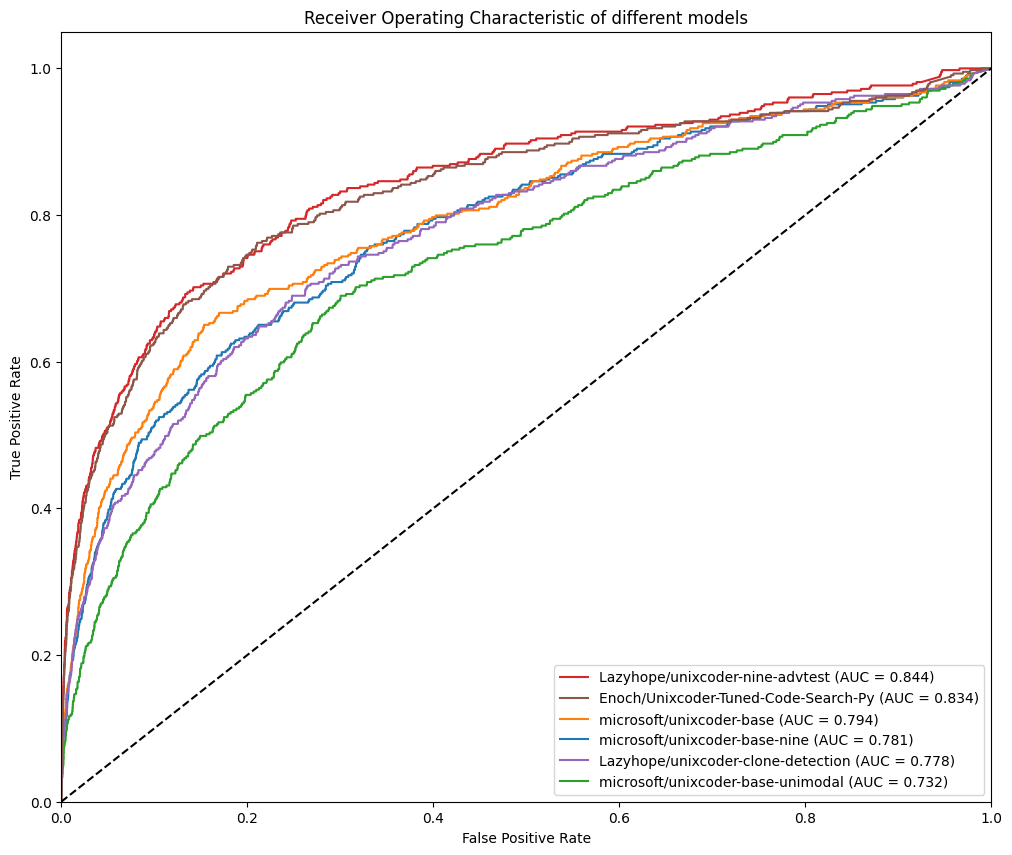

In [15]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

model_auc = {}
y_true = df['topic1'] == df['topic2']
fig = plt.figure(figsize=(12, 10))


def roc(model_name):
    y_score = df[model_name]
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    model_auc[model_name] = roc_auc

    plt.plot(fpr, tpr, label=model_name)


for model in unixcoder_model_names:
    roc(model)

# Order labels by each model's auc score
handles, labels = plt.gca().get_legend_handles_labels()
order = sorted(range(len(labels)), key=lambda k: -model_auc[labels[k]])
ordered_handles = [handles[idx] for idx in order]
ordered_labels = [f'{labels[idx]} (AUC = {model_auc[labels[idx]]:.3f})' for idx in order]
plt.legend(ordered_handles, ordered_labels, loc="lower right")

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic of different models')
plt.savefig('roc_code_evaluation_train_315.eps')
plt.show()

In [16]:
model_auc

{'microsoft/unixcoder-base-nine': 0.7813223029842783,
 'microsoft/unixcoder-base': 0.7944899747310713,
 'microsoft/unixcoder-base-unimodal': 0.7323135091156141,
 'Lazyhope/unixcoder-nine-advtest': 0.8436938508533173,
 'Lazyhope/unixcoder-clone-detection': 0.7777956076205984,
 'Enoch/Unixcoder-Tuned-Code-Search-Py': 0.8341614225532962}